# California Wildfire Feature Engineering
### Owners: Sam Neuschwander, Abigail Witt, Spencer Zwiener

Additional information about all datasets, features, and joins can be found in the "Project Writeup" document.

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
plt.rcParams['figure.figsize'] = [40, 40]
# display all columns
pd.set_option('display.max_columns', None)

## Transmission Lines Data

In [2]:
# read in shapefile of Transmission Lines
shp_df = gpd.read_file('Transmission_Line.shp')

#### Curation Step 1: To ensure our transmission lines only consists of lines that were created prior to the wildfires, in our wildfire dataset, we are removing any transmission lines data with a Creator_Date after 2014-04-01

In [3]:
# First keeping an object of our outliers, so we can see what was removed.
shp_df_outliers = shp_df.loc[shp_df['Creator_Da'] > '2014-04-01']

In [4]:
# Filtering to transmission lines data with a Creator_Date after 2014-04-01
shp_df = shp_df.loc[shp_df['Creator_Da'] < '2014-04-01']

In [5]:
# View Transmission data (post '2014-04-01')
shp_df.head()

OBJECTID       Name   kV  kV_Sort Owner       Status Circuit Type  \
0         1  AMP 115kV  115    115.0   AMP  Operational  Single   OH   
1         2  AMP 115kV  115    115.0   AMP  Operational  Single   OH   
2         3  AMP 115kV  115    115.0   AMP  Operational  Single   OH   
3         4  AMP 115kV  115    115.0   AMP  Operational  Single   OH   
4         5  ANZA 34kV   34     34.0  ANZA  Operational  Single   OH   

            Legend  Length_Mil       Length_Fee TLine_Name        Source  \
0  Other_110_161kV         2.0   10879.98077483        NaN           AMP   
1  Other_110_161kV         3.0   16505.41123852        NaN           AMP   
2  Other_110_161kV         1.0    3807.24014248        NaN           AMP   
3  Other_110_161kV         1.0    6135.61557739        NaN           AMP   
4    Other_33_92kV        24.0  127189.40561552        NaN  City of Anza   

               Comments Creator  Creator_Da       Last_Edito  Last_Edi_1  \
0                   NaN  FTHONG  2012-08-31  SVC_AGIS_SQLADM  2016-04-25   
1                   NaN  FTHONG  2012-08-31  SVC_AGIS_SQLADM  2016-04-25   
2                   NaN  FTHONG  2012-08-31  SVC_AGIS_SQLADM  2016-04-25   
3  Partially underwater  FTHONG  2012-08-31  SVC_AGIS_SQLADM  2016-04-25   
4                   NaN  FTHONG  2012-08-24  SVC_AGIS_SQLADM  2016-04-25   

                                 GlobalID    SHAPE_Leng  \
0  {EE79BAA8-EC31-4EA3-89A1-AA93DDD2E1FE}   4198.109678   
1  {27657F83-1FA1-433E-90E4-7D8273D24740}   6368.076880   
2  {1A61BBCC-4D0D-4BD1-A9BF-65DBCE40E875}   1470.170052   
3  {16F5AE4F-5112-4C67-8D8D-B3CB0483231F}   2368.338138   
4  {B2B57C70-B09E-46E5-A7BF-7EC354D4436F}  46585.778214   

                                            geometry  
0  LINESTRING (-13608018.951 4547326.915, -136080...  
1  LINESTRING (-13608044.414 4547272.768, -136080...  
2  LINESTRING (-13613422.397 4548276.164, -136134...  
3  LINESTRING (-13613131.635 4549619.954, -136131...  
4  LINESTRING (-12994452.454 3989231.906, -129944...

In [6]:
# looking at dataset size
shp_df.shape

(6789, 21)

<AxesSubplot:>

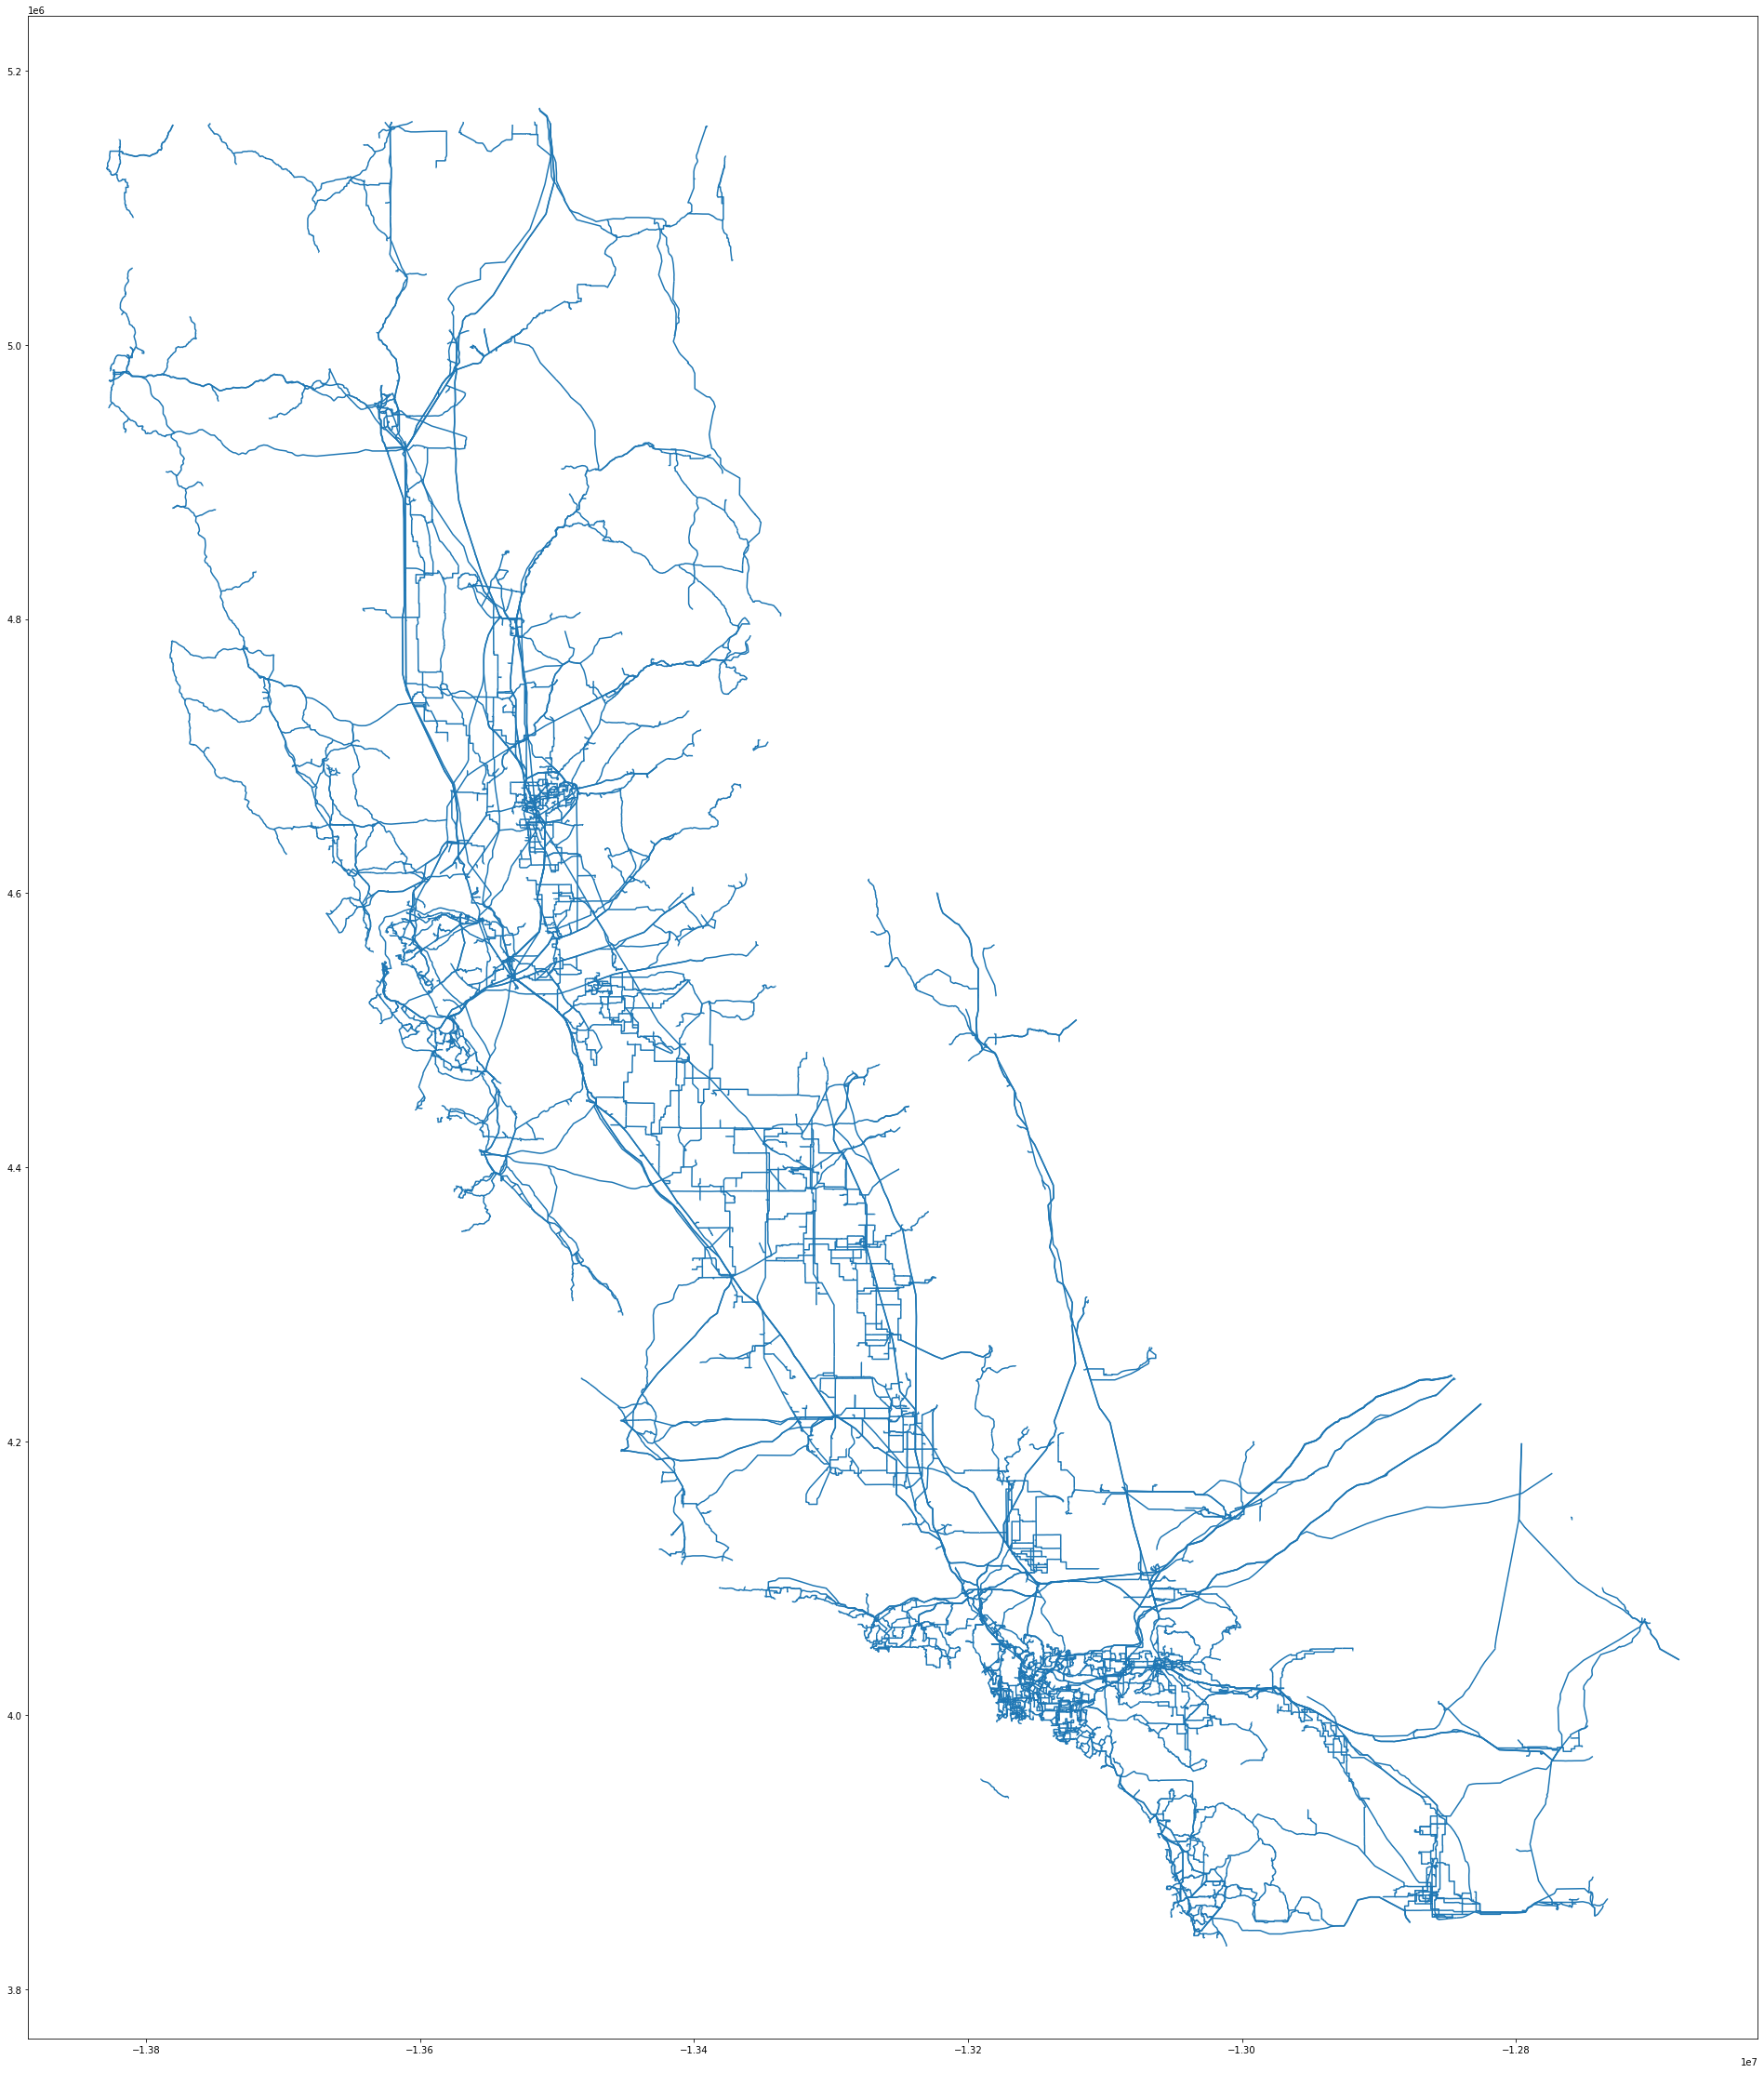

In [7]:
shp_df.plot()

#### Curation Step 2: filter data to only Overhead powerlines (OH) as the others do not pose a threat of wildfire (underground or underwater)

In [8]:
# filter data to only Overhead powerlines (OH) as the others do not pose a threat of wildfire (underground or underwater)
oh_df = shp_df.loc[shp_df['Type'] == 'OH']

<AxesSubplot:>

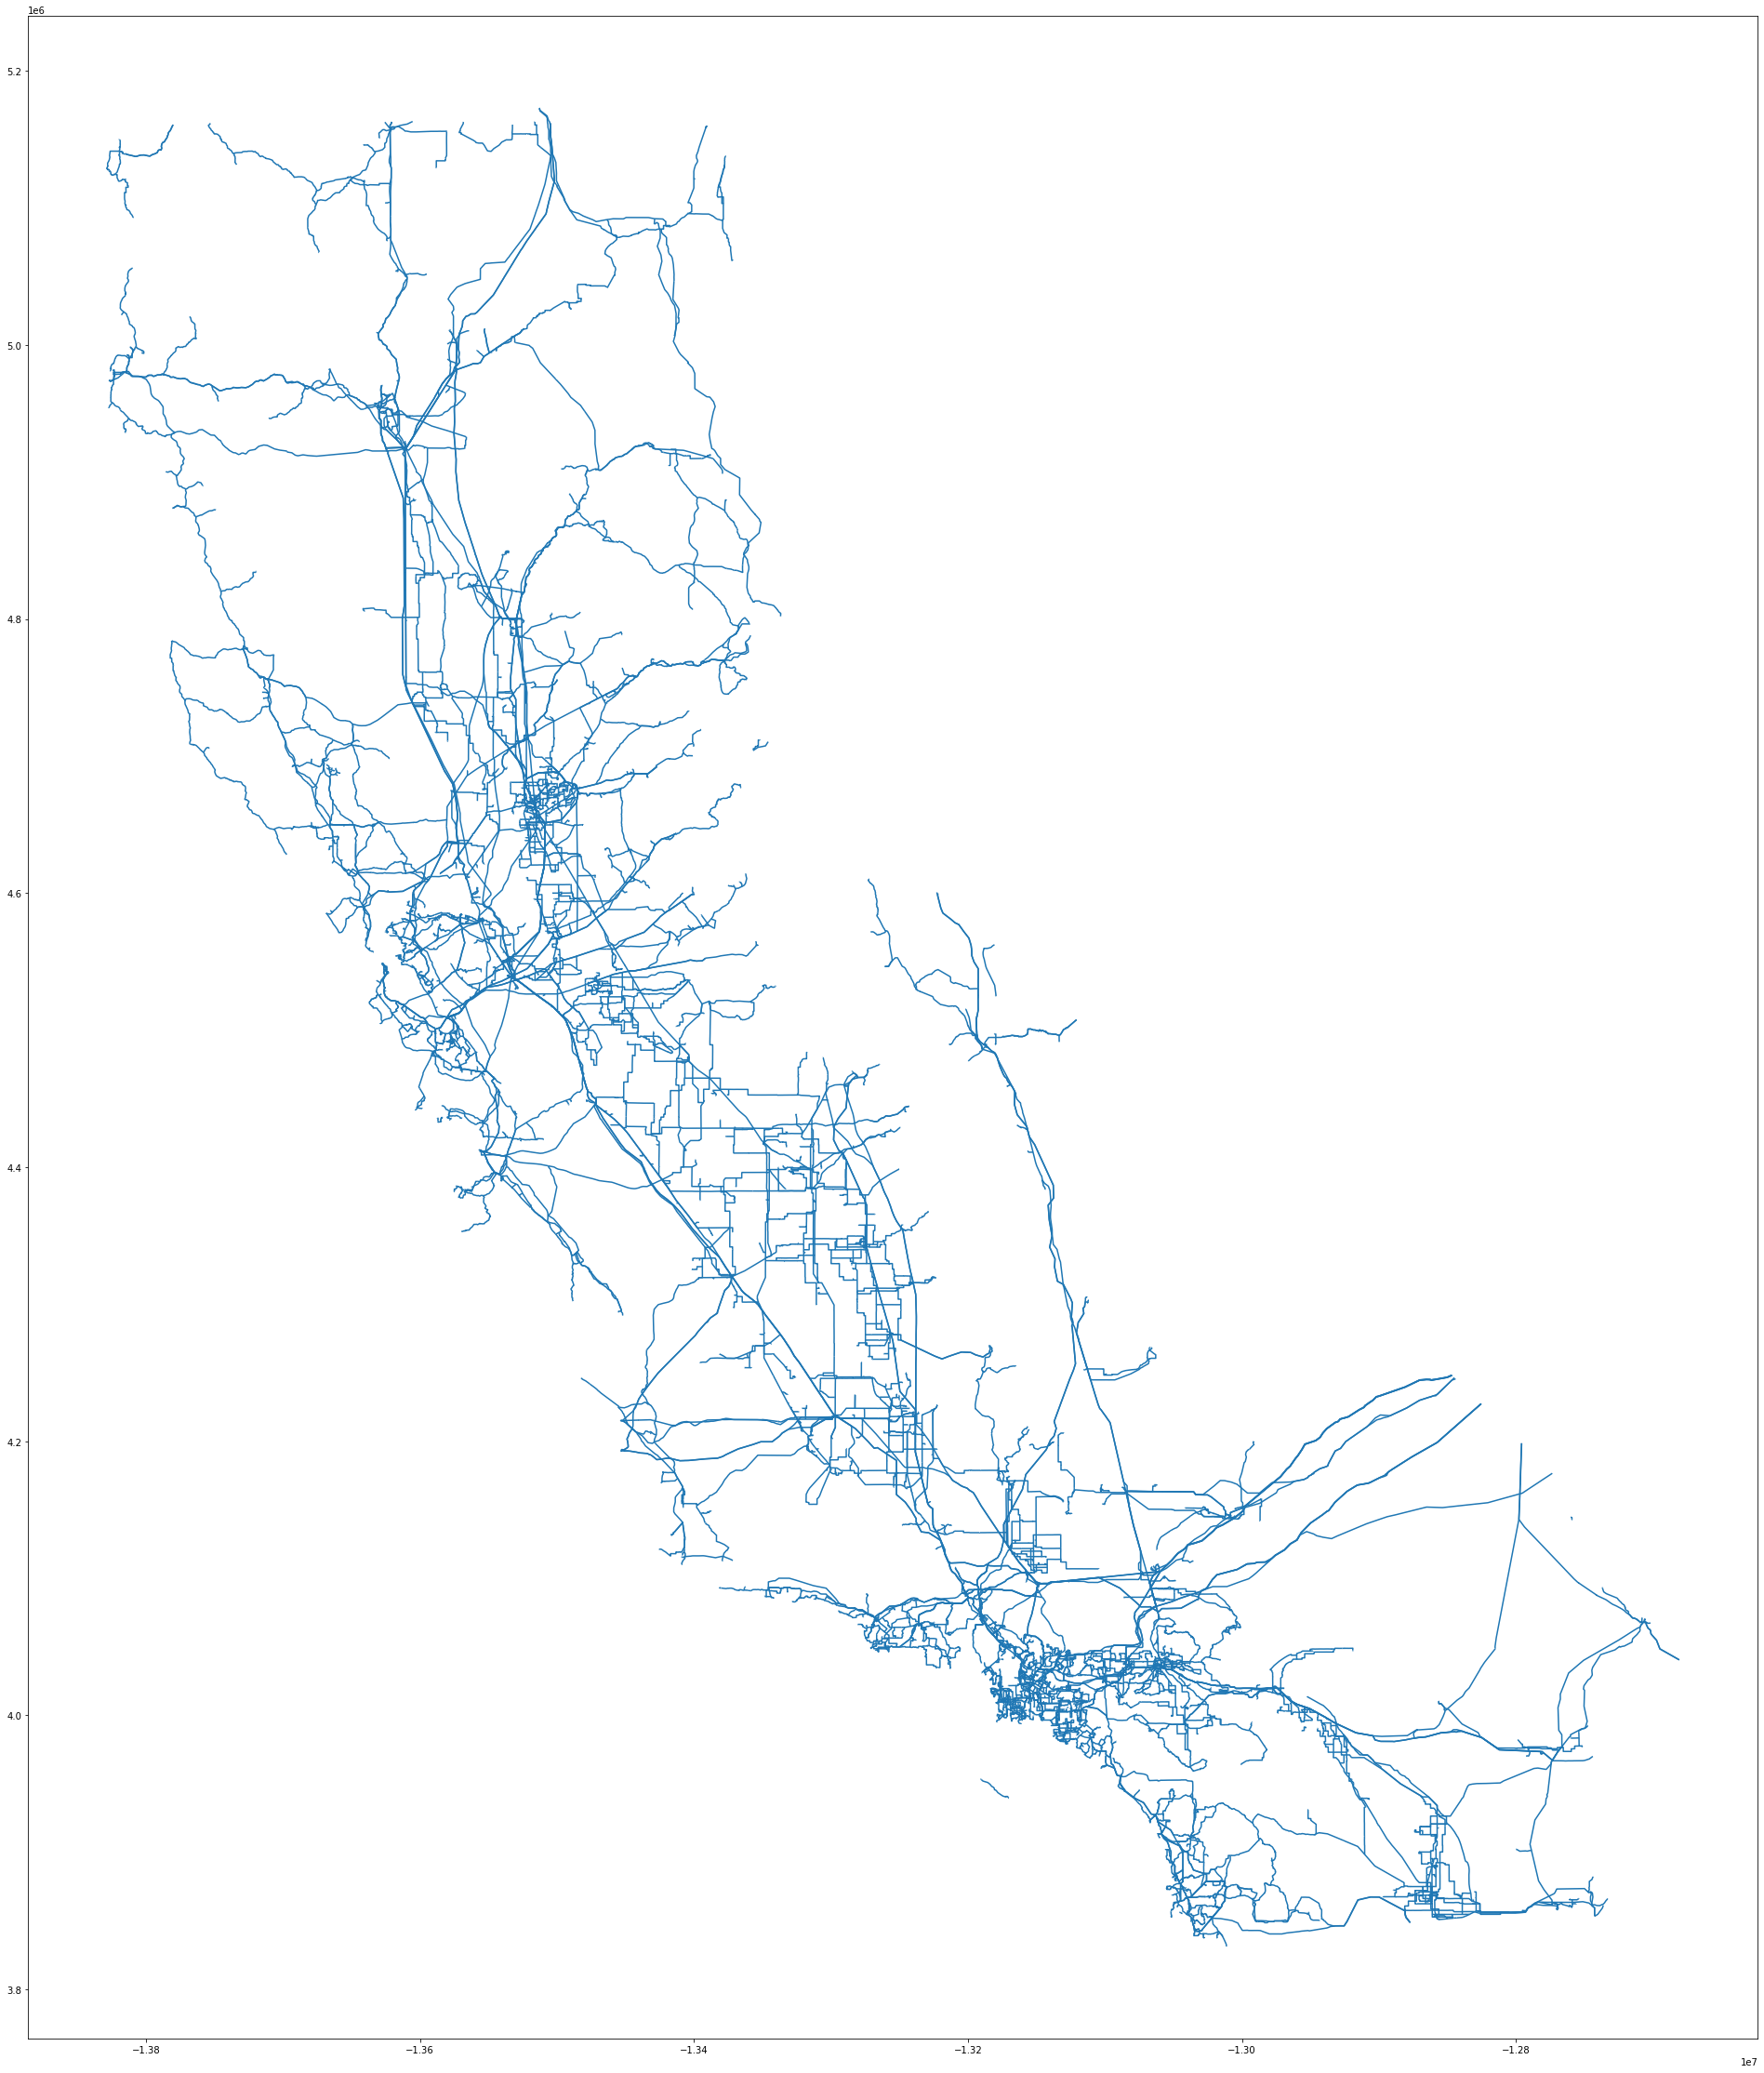

In [9]:
oh_df.plot()

In [10]:
# looking at dataset size
oh_df.shape

(6662, 21)

#### Creating Buffer of 200 Meters that will be used to analyze Wildfires that are within transmission lines

In [11]:
# creating a buffer aroud the powerlines. This will help when merging with wildfires near the powerlines
buffered_oh = oh_df.buffer(200)
# converting the buffered polygon from a geoseries, to a geodataframe.
buffered_oh = gpd.GeoDataFrame(geometry=buffered_oh)

In [12]:
# viewing the data
buffered_oh

geometry
0     POLYGON ((-13607826.280 4547379.955, -13607380...
1     POLYGON ((-13613614.310 4548105.534, -13613630...
2     POLYGON ((-13613623.671 4548511.067, -13613624...
3     POLYGON ((-13613312.050 4549705.819, -13613313...
4     POLYGON ((-12994264.451 3989303.082, -12994194...
...                                                 ...
6808  POLYGON ((-13650667.027 4959966.625, -13650678...
6809  POLYGON ((-13631097.569 4955268.974, -13631100...
6810  POLYGON ((-13630523.582 4954736.549, -13630596...
6811  POLYGON ((-12705691.078 4068341.189, -12705689...
6812  POLYGON ((-13362510.066 4215965.879, -13362223...

[6662 rows x 1 columns]

In [13]:
# confirming type
type(buffered_oh)

geopandas.geodataframe.GeoDataFrame

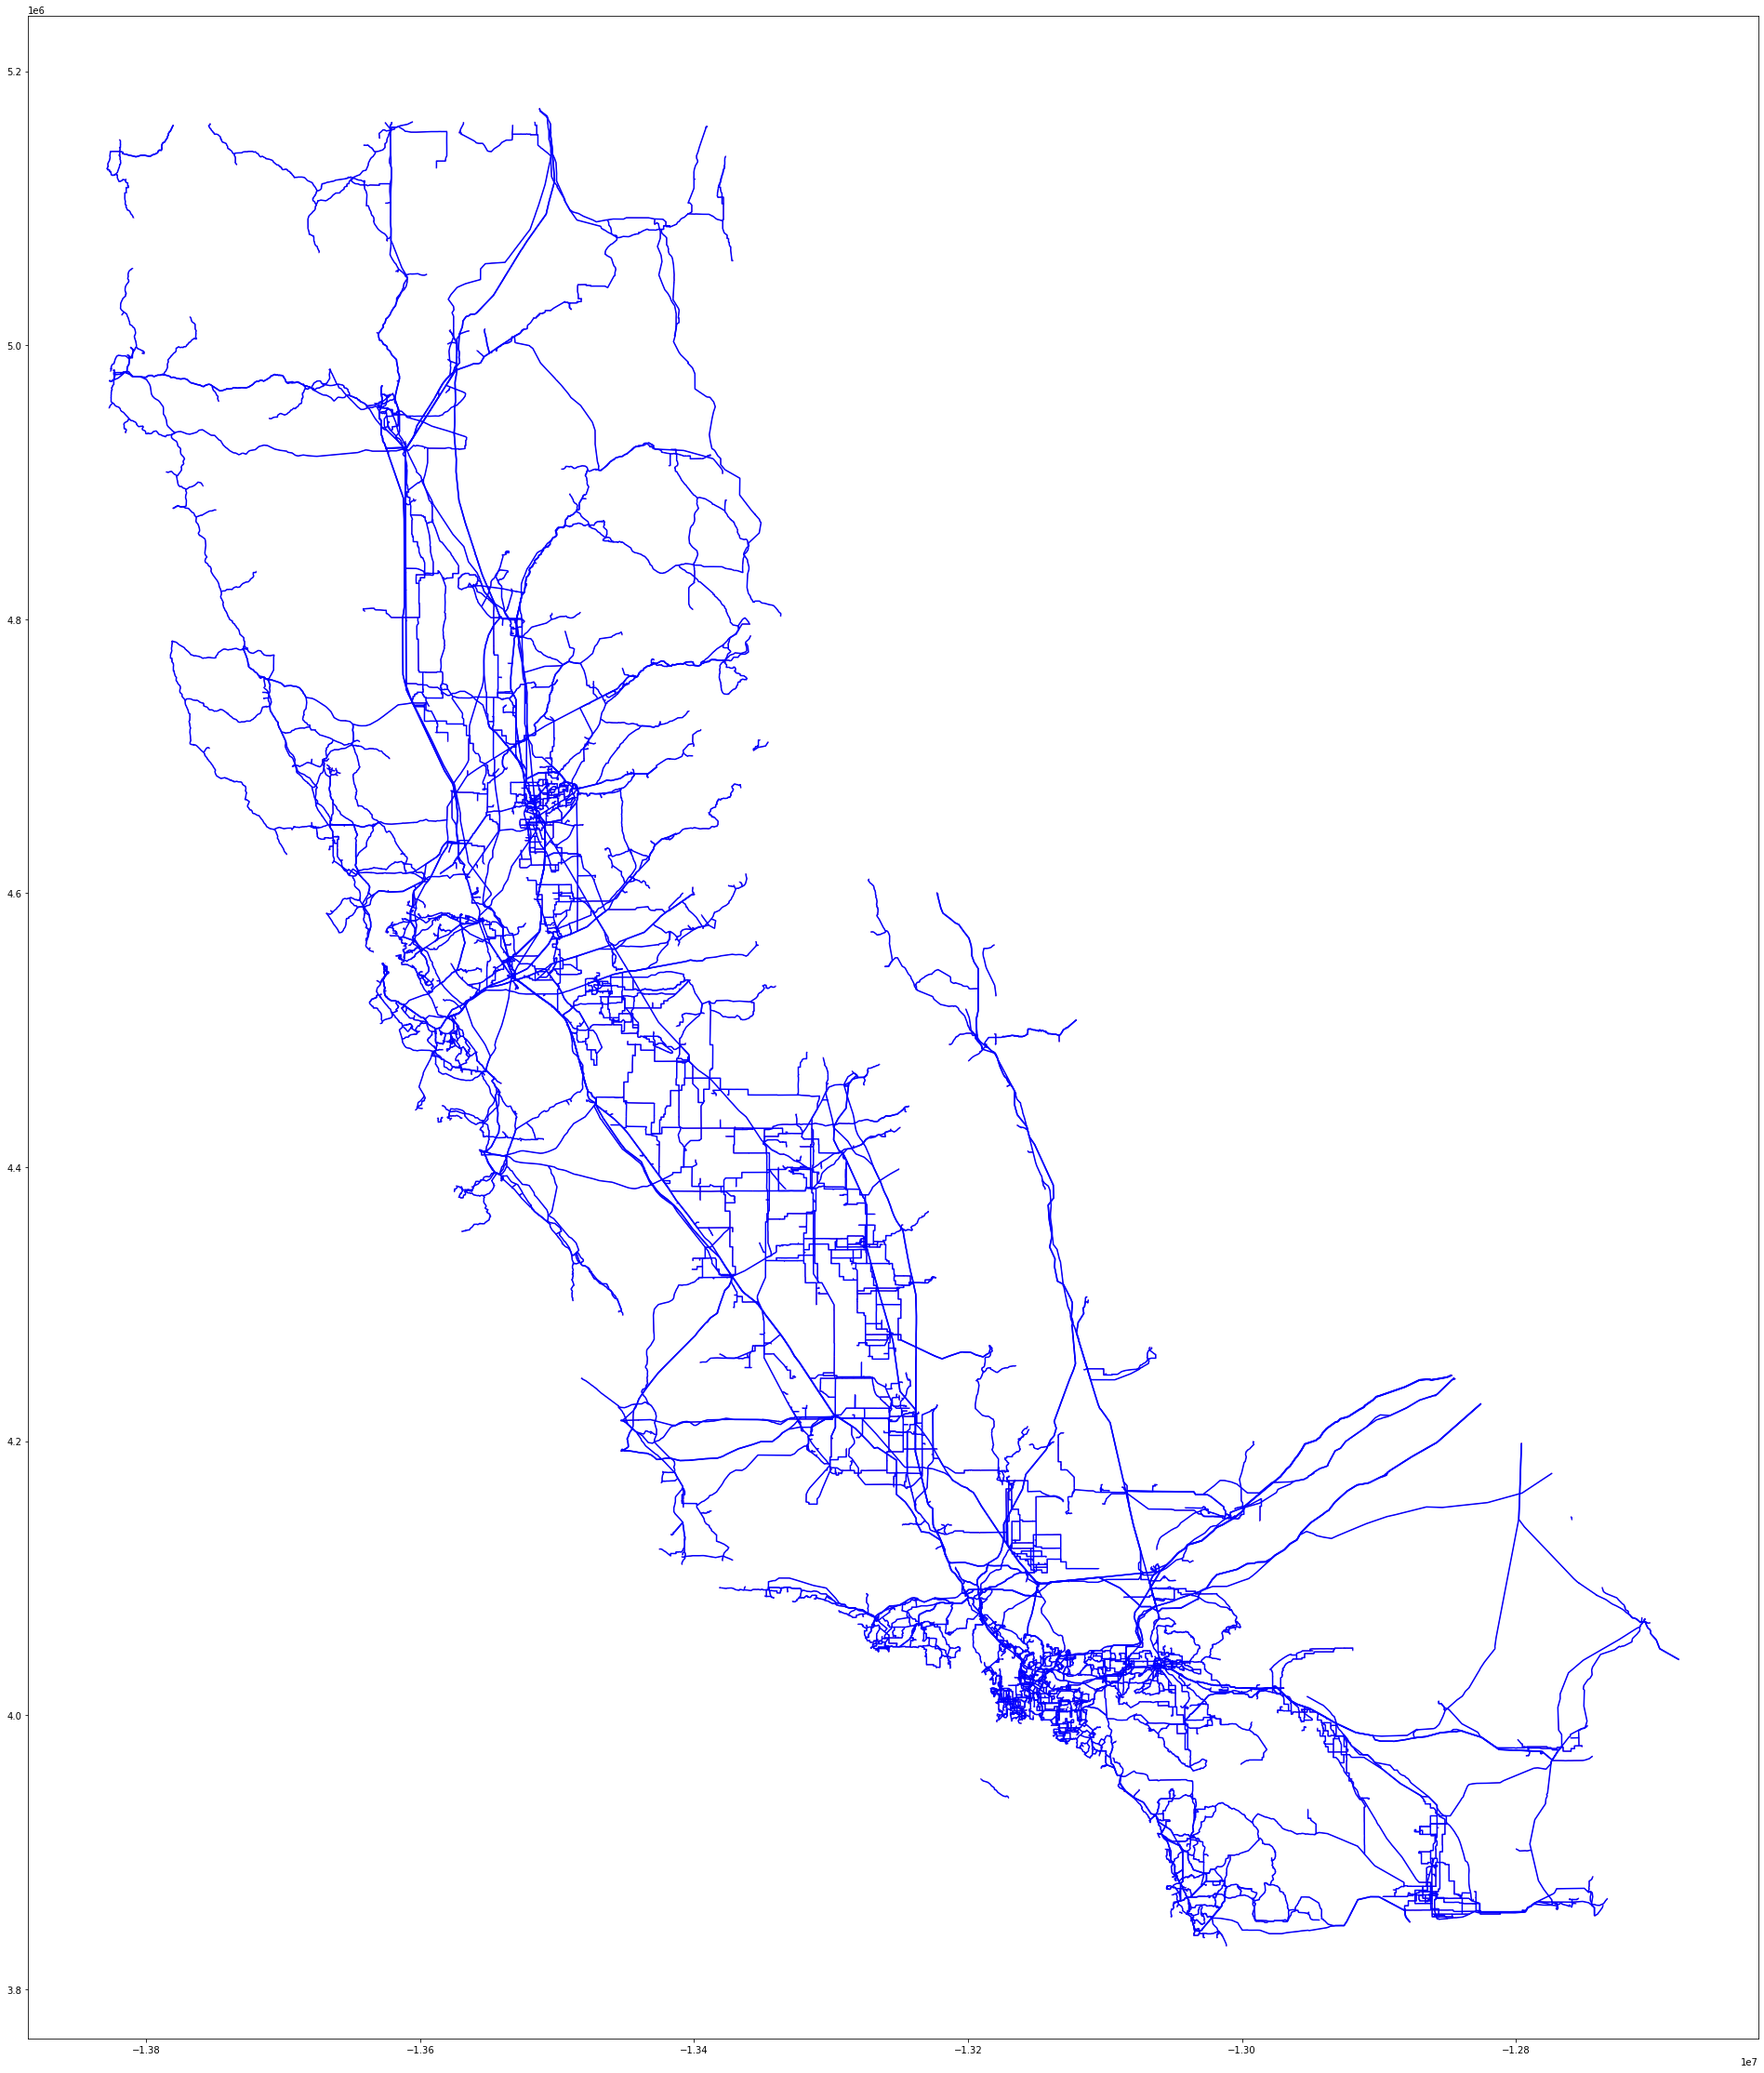

In [14]:
#plot the lines and the buffers (the buffer is too small to show, can increase the size, and the buffer will show)
ax = buffered_oh.plot(color = 'red')

oh_df.plot(ax=ax, color = 'blue')
plt.show()

## Wildfire Data

In [15]:
# read in shapefile of Wildfires, filtered to only the data within our boundbox -- processing time is faster
incidents_df = gpd.read_file('Incidents.shp')

In [16]:
fire_shp_df = incidents_df
fire_shp_df.shape

(286411, 95)

#### Curation Step 1: Filter to wildfires in California

In [18]:
# Filtering dataset to only California Wildfires.
fire_shp_df = fire_shp_df.loc[fire_shp_df['POOState'] == 'US-CA']

#### Curation Step 2: Filter out the outliers

In [19]:
# First keeping an object of our outliers, so we can see what was removed.
fire_shp_df_outliers = fire_shp_df.loc[fire_shp_df['FireDiscov'] < '2014-01-01']

In [20]:
# Cleaning up data. Two incidents had dates that looked to be outliers. Likely key errors, so only including data starting in 2014.
fire_shp_df = fire_shp_df.loc[fire_shp_df['FireDiscov'] > '2014-01-01']

<AxesSubplot:>

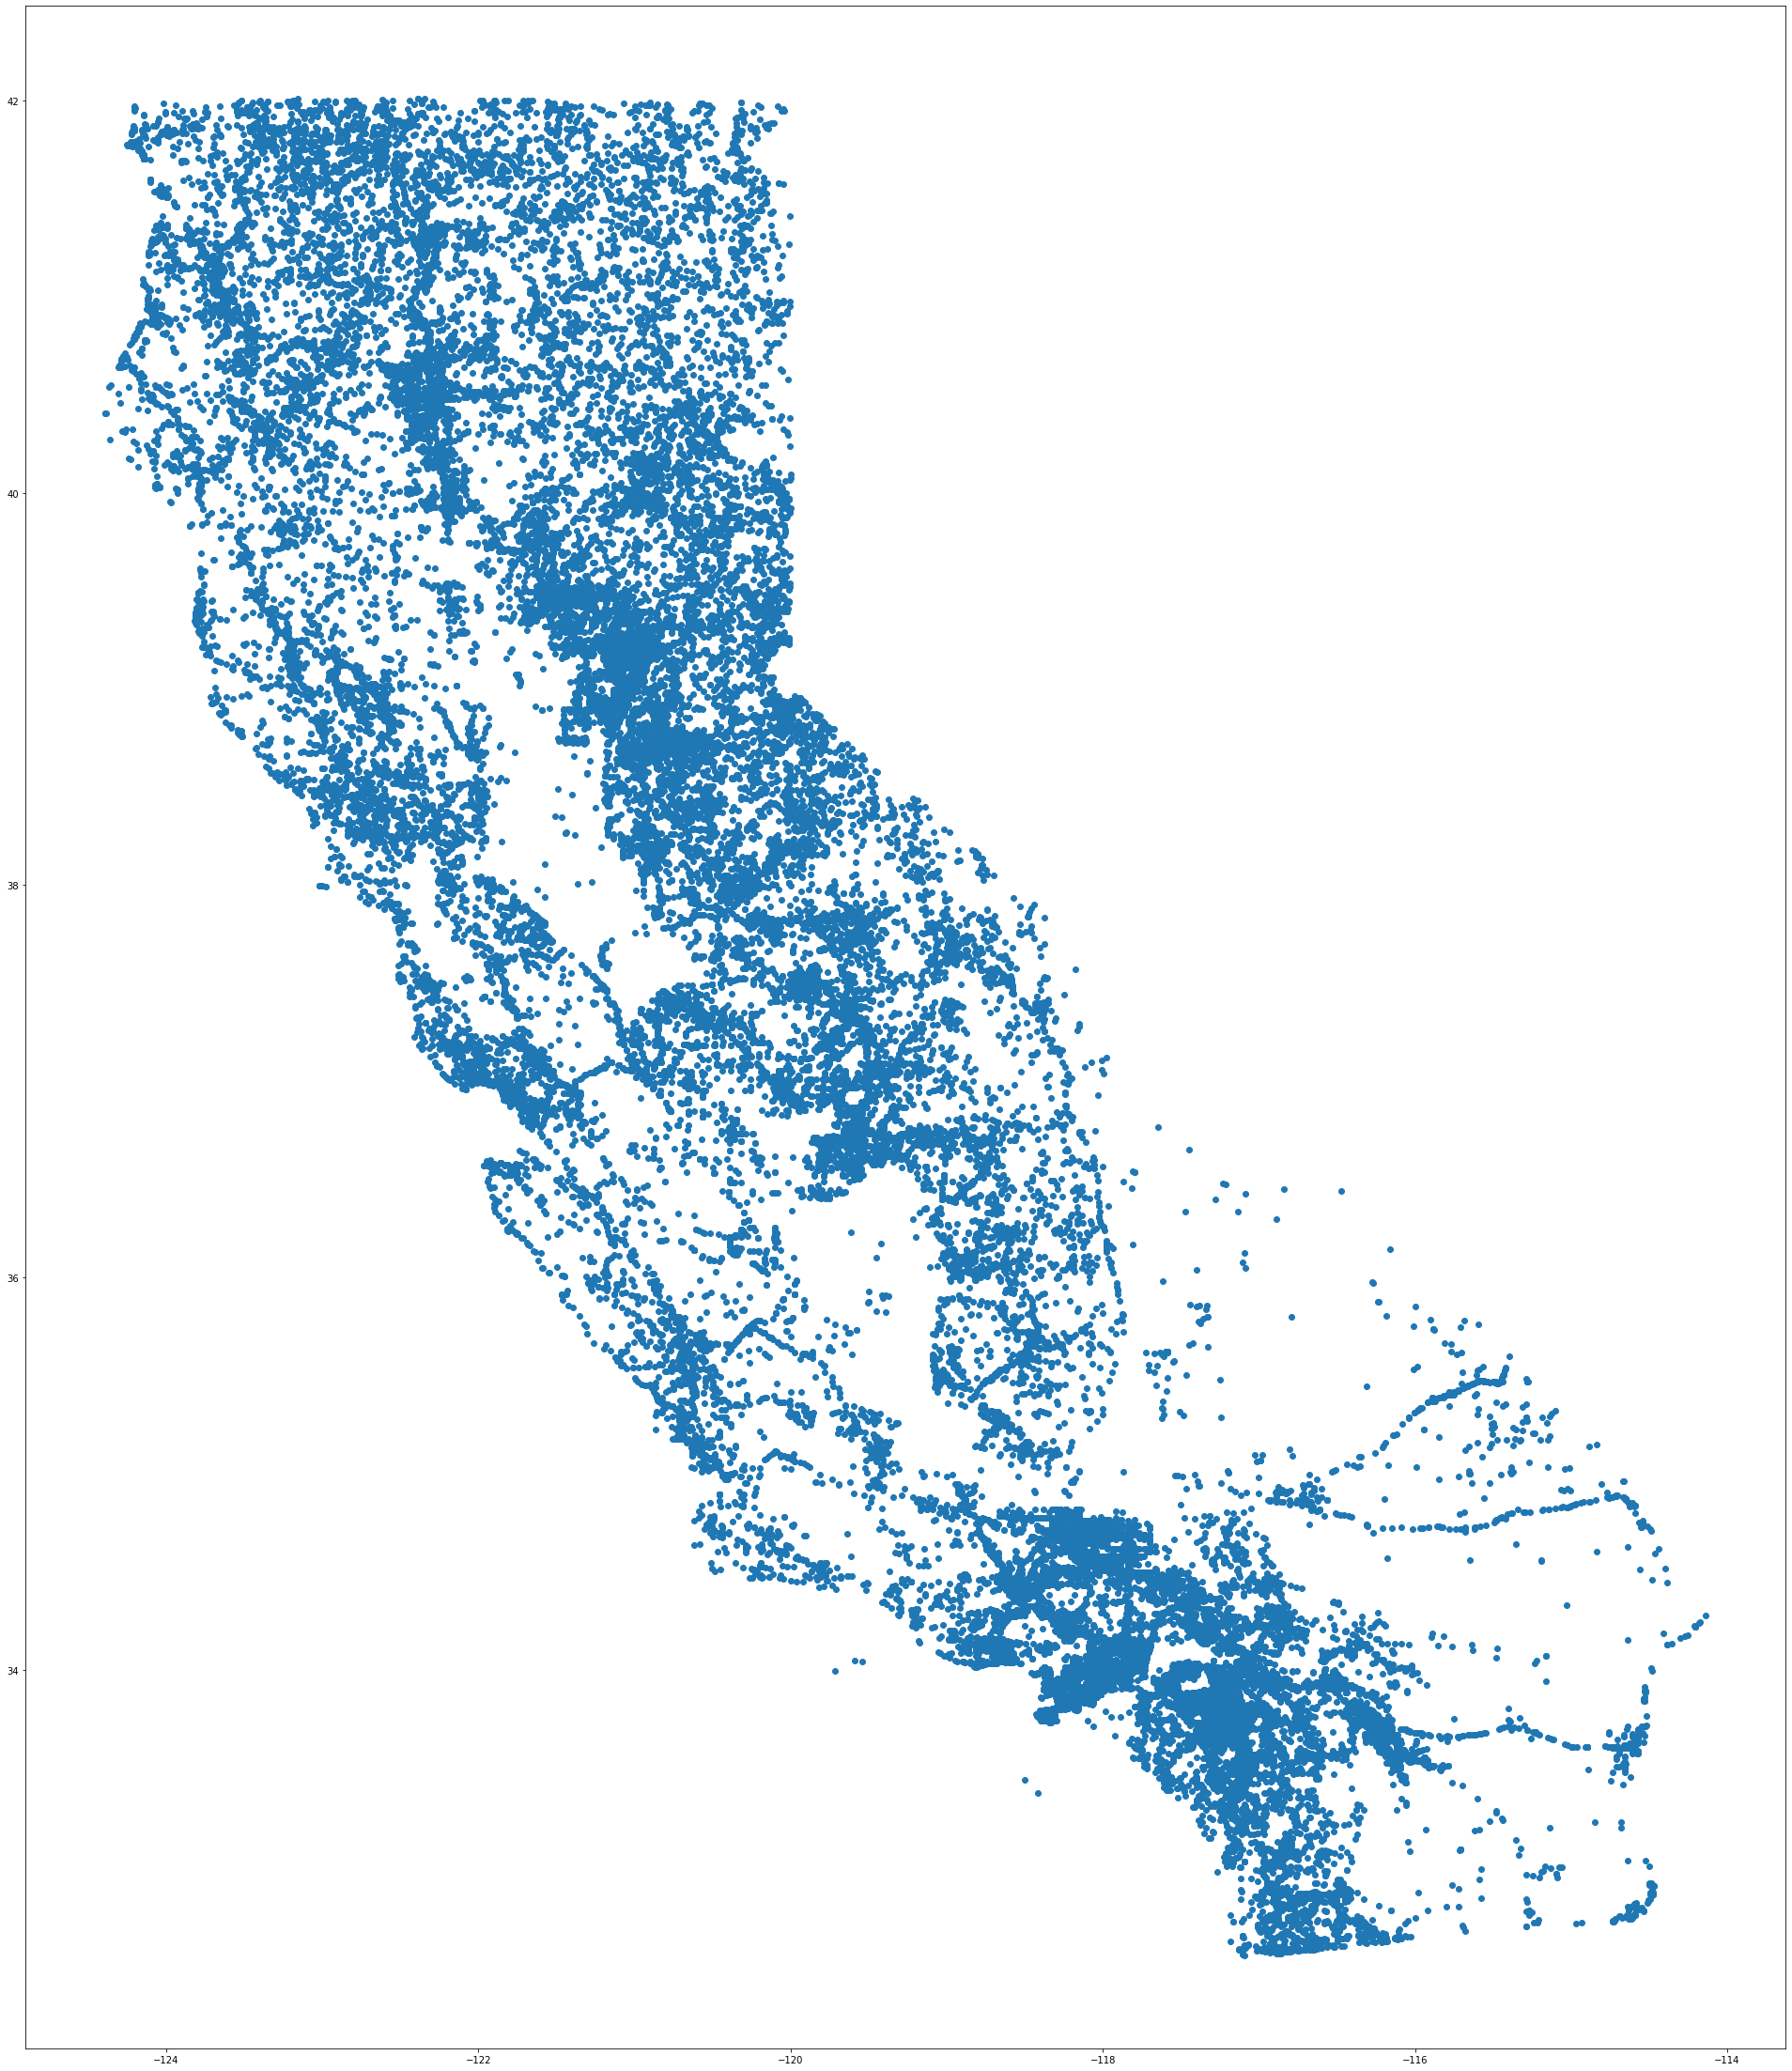

In [21]:
fire_shp_df.plot()

In [22]:
fire_shp_df.shape

(72552, 95)

In [23]:
shp_df.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [24]:
fire_shp_df.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

#### Curation Step 3: Update the coordinate reference system (CRS) to 3857 so that we can use meters as a distance measurement and have a common CRS with Transmission Lines data

In [25]:
# Updating CRS of Wildfire data
fire_shp_df = fire_shp_df.to_crs('epsg:3857')


In [26]:
fire_shp_df.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

#### Join 1: Joing curated wildfire data to the curated, buffered Transmission lines using spatial join, within predicate
- Within means that the resulting geodataframe will contain rows where the geometries from wildfires are completely within the geometries of the buffered tranmsission lines http://shapely.readthedocs.io/en/latest/manual.html#binary-predicates 
- This is required because the geometry component of the wildfire dataset is a Point

In [27]:
# Joining the widlfires to the transmission lines
join_df = gpd.sjoin(fire_shp_df, buffered_oh, how='left', predicate='within')

In [28]:
# shows that our data has now changed, sjoin worked
join_df.shape

(77768, 96)

In [29]:
# getting a sense for how many sjoins occurred by counting the number of unique occurrences in the index_right column
join_df['index_right'].nunique()

2025

#### Feature 1: Close to Lines

In [30]:
# creating a feature to mark a column as Y/N if they fall within proximity of Transmission Line

# Initialing the New Feature to 'N'
join_df['CloseToLines'] = 'N'
# Changing new feature to 'Y' if it was within a powerline from our spatial join (index_right is not 'NaN')
join_df.loc[join_df['index_right'].notnull(), 'CloseToLines'] = 'Y'

In [31]:
# view the new feature
join_df.head()

OBJECTID  SourceOID ABCDMisc ADSPermiss Containmen ControlDat CreatedByS  \
0         1    7747595      NaN    DEFAULT        NaN        NaN    lacocad   
1         2    6384391      NaN    DEFAULT        NaN        NaN   firecode   
2         3    1383752      NaN    DEFAULT        NaN        NaN   firecode   
3         4   22499589      NaN    DEFAULT        NaN        NaN      cfcad   
4         5   23869477      NaN    DEFAULT        NaN        NaN    lacocad   

   IncidentSi  DiscoveryA DispatchCe  EstimatedC  FinalAcres  FinalFireR  \
0         NaN        0.10     CALACC         NaN         NaN         NaN   
1         NaN         NaN     CAMVIC         NaN         NaN         NaN   
2         NaN         NaN        NaN         NaN         NaN         NaN   
3         NaN        0.10     CARRCC         NaN         NaN         NaN   
4         NaN        0.01     CALACC         NaN         NaN         NaN   

  FinalFir_1 FinalFir_2 FireBehavi FireBeha_1 FireBeha_2 FireBeha_3  \
0        NaN        NaN        NaN        NaN        NaN        NaN   
1        NaN        NaN        NaN        NaN        NaN        NaN   
2        NaN        NaN        NaN        NaN        NaN        NaN   
3        NaN        NaN        NaN        NaN        NaN        NaN   
4        NaN        NaN        NaN        NaN        NaN        NaN   

      FireCause FireCauseG FireCauseS FireCode FireDepart  FireDiscov  \
0       Unknown        NaN        NaN      NaN        NaN  2020-02-28   
1           NaN        NaN        NaN     MC2S        NaN  2019-07-01   
2           NaN        NaN        NaN     KA82        NaN  2016-06-20   
3  Undetermined        NaN        NaN      NaN        NaN  2021-11-25   
4  Undetermined        NaN        NaN      NaN        NaN  2022-11-21   

  FireMgmtCo FireOutDat  FireStrate  FireStra_1  FireStra_2  FireStra_3  \
0        NaN        NaN         NaN         NaN         NaN         NaN   
1        NaN        NaN         NaN         NaN         NaN         NaN   
2        NaN        NaN         NaN         NaN         NaN         NaN   
3        NaN        NaN         NaN         NaN         NaN         NaN   
4        NaN        NaN         NaN         NaN         NaN         NaN   

  FSJobCode FSOverride  GACC ICS209Repo ICS209Re_1 ICS209Re_2 ICS209Re_3  \
0       NaN        NaN  OSCC        NaN        NaN        NaN        NaN   
1       NaN        NaN  OSCC        NaN        NaN        NaN        NaN   
2       NaN        NaN  ONCC        NaN        NaN        NaN        NaN   
3       NaN        NaN  OSCC        NaN        NaN        NaN        NaN   
4       NaN        NaN  OSCC        NaN        NaN        NaN        NaN   

  IncidentMa        IncidentNa IncidentSh IncidentTy Incident_1  InitialLat  \
0        NaN        LAC-066100        NaN         WF         FI   33.808980   
1        NaN          SYCAMORE        NaN         WF         FI         NaN   
2        NaN       RATTLESNAKE        NaN         WF         FI         NaN   
3        NaN  E 4TH ST /S D ST        NaN         WF         FI   33.782437   
4        NaN        LAC-396331        NaN         WF         FI   33.941810   

   InitialLon  InitialRes InitialR_1                                 IrwinID  \
0  -118.18070         NaN        NaN  {6A311ABB-DF4F-4947-B8DD-3900BDA784F6}   
1         NaN         NaN        NaN  {1AF2C949-B159-4D8F-8D39-90CB58BC5DD5}   
2         NaN         NaN        NaN  {1B179EA1-97CE-4699-915B-374754BCBC5B}   
3  -117.22858         NaN        NaN  {E61E387B-4ED7-4971-9604-C5D7391FAF77}   
4  -118.30902         NaN        NaN  {D24123EC-7707-4229-A206-9111FE4B6020}   

   IsFireCaus  IsFireCode  IsFSAssist  IsMultiJur  IsReimburs  IsTrespass  \
0         NaN           0         NaN         NaN         NaN         NaN   
1         NaN           0         1.0         0.0         1.0         0.0   
2         NaN           0         1.0         0.0         0.0         0.0   
3         NaN           0        

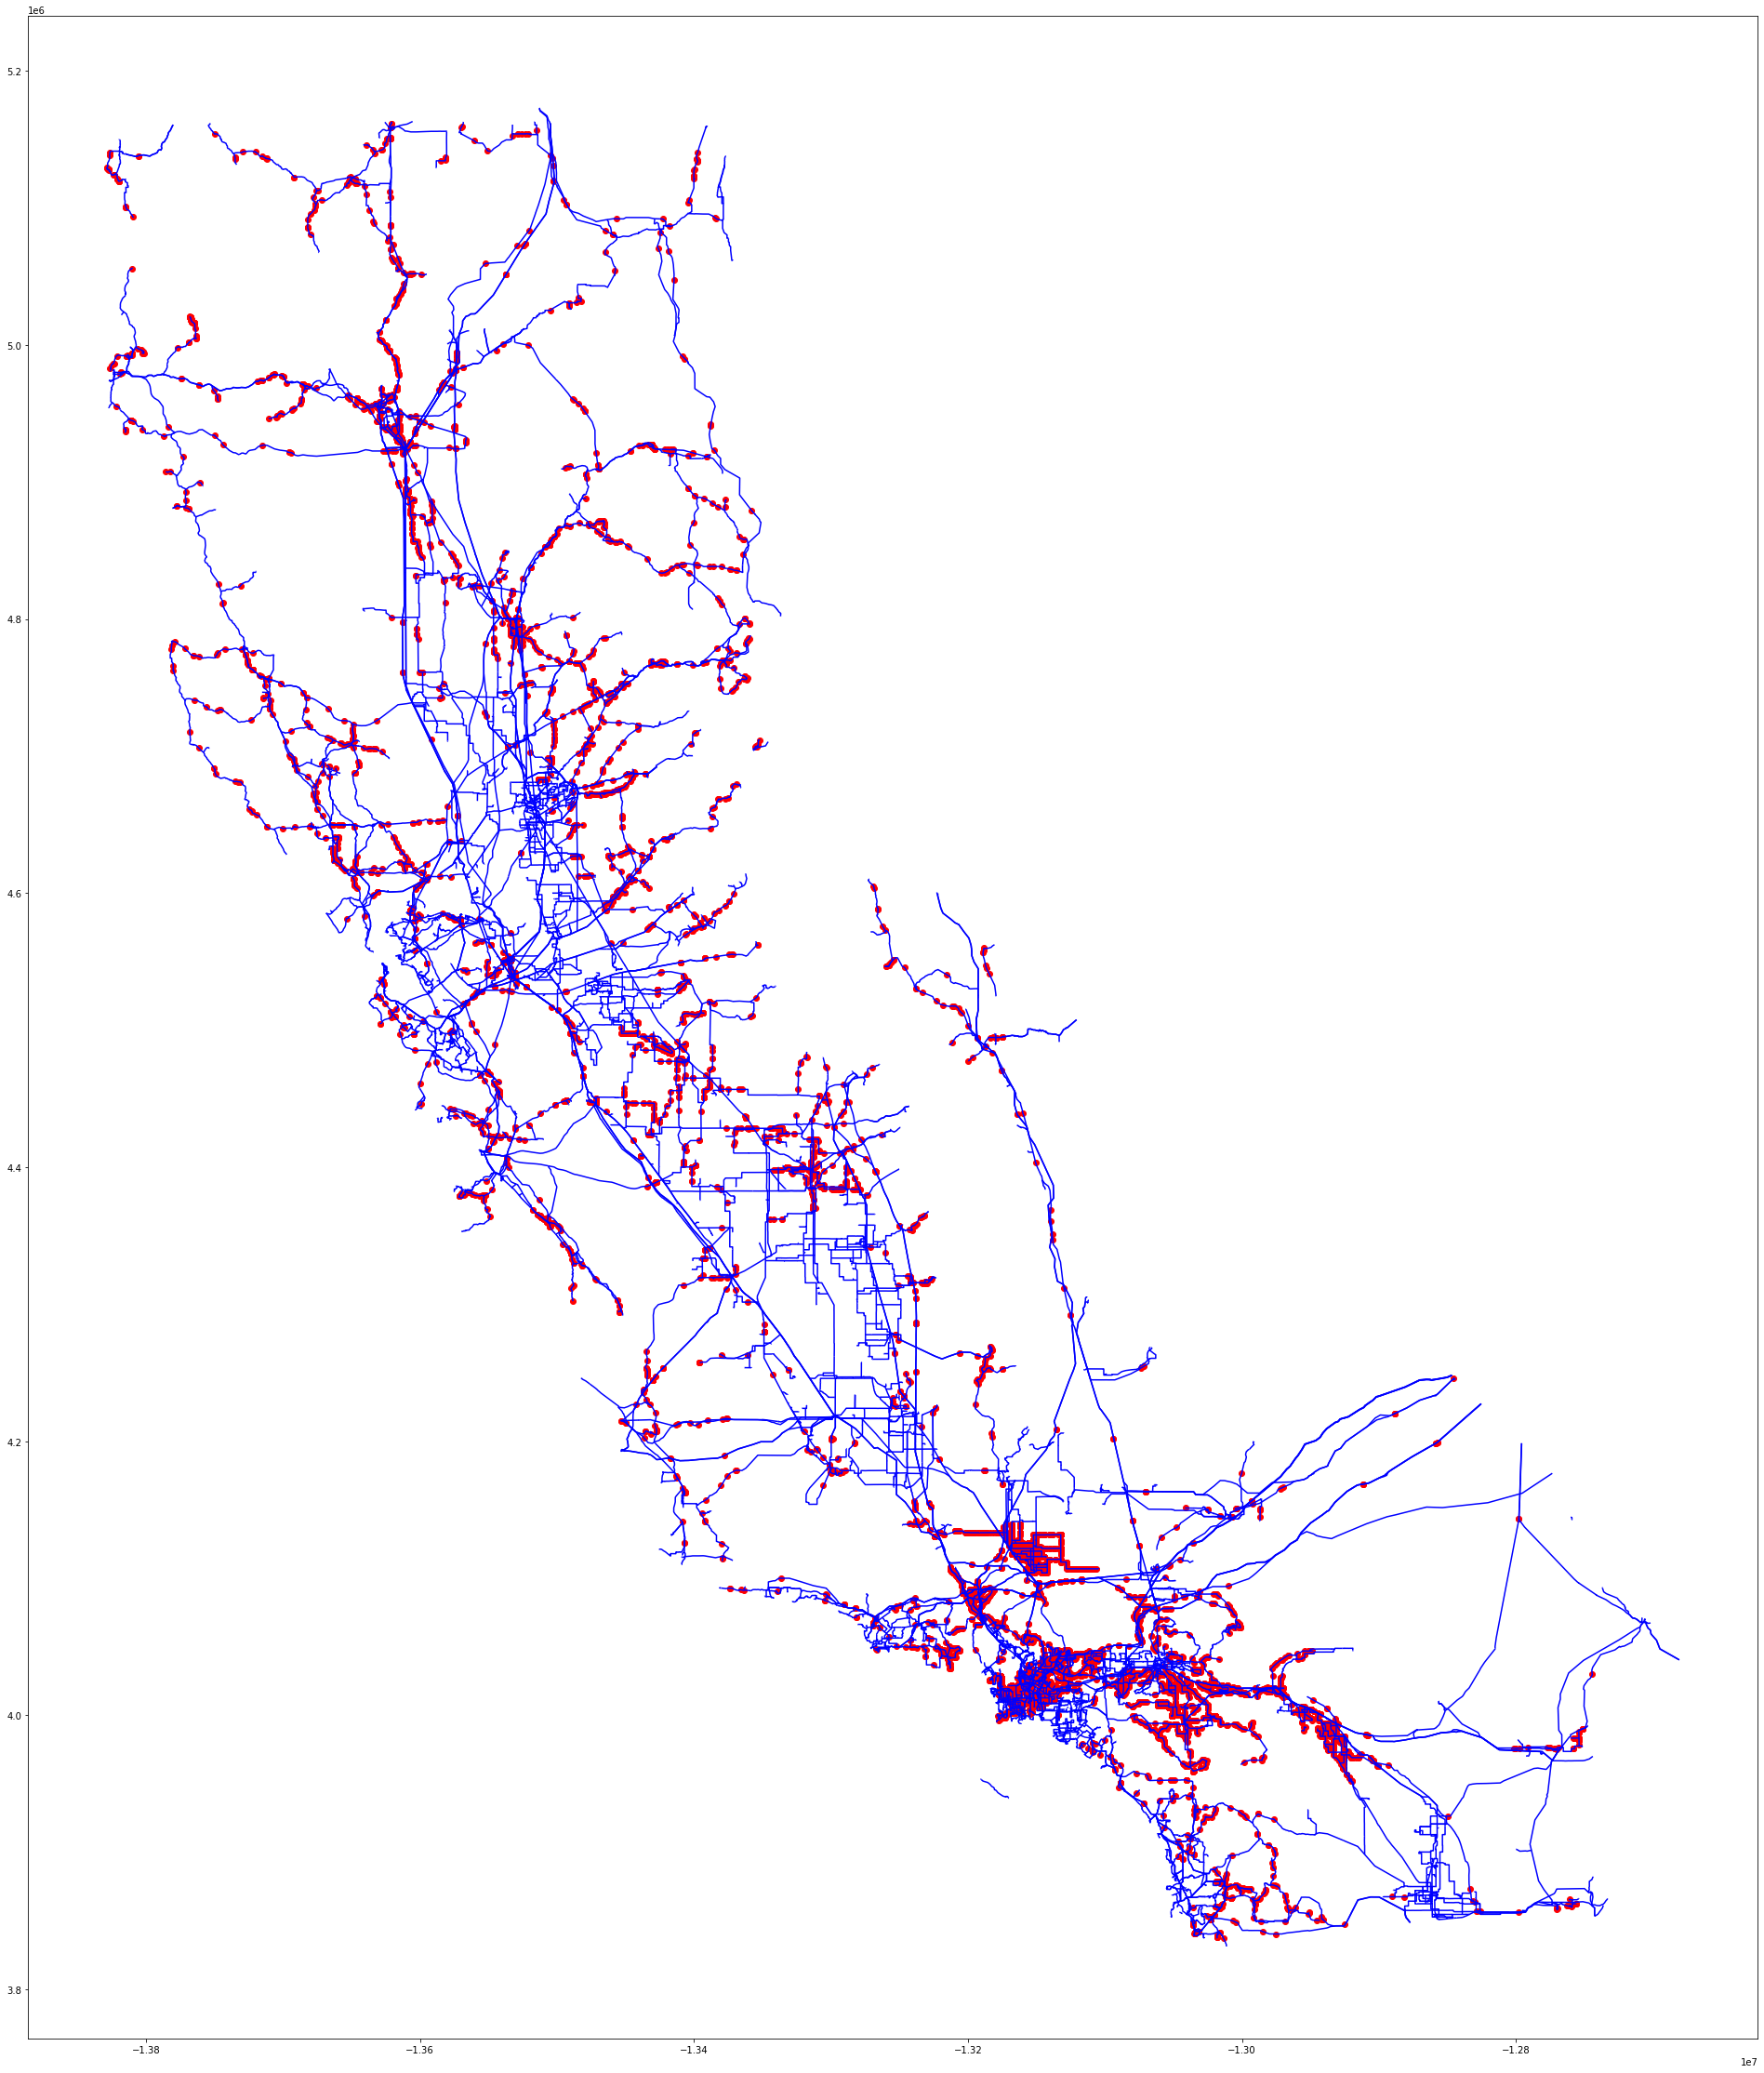

In [32]:
# ploting the transmission lines, and wildfires that fell within close proximity to them
ax = join_df[join_df['CloseToLines'] == 'Y'].plot(color='red')

oh_df.plot(ax=ax,color='blue')
plt.show()


## Outlier Data
- This is the data that was removed from our Tranmission Line dataset and our Wildfire Dataset

In [33]:
# Transmission Line Data Outliers
shp_df_outliers

OBJECTID                  Name   kV  kV_Sort  Owner       Status  \
104        105             ESJ 250kV  250    250.0    ESJ     Proposed   
105        106             ESJ 500kV  500    500.0    ESJ     Proposed   
290        291             IID 230kV  230    230.0    IID  Operational   
291        292             IID 230kV  230    230.0    IID  Operational   
292        293             IID 230kV  230    230.0    IID  Operational   
429        430           LADWP 230kV  230    230.0  LADWP     Proposed   
3480      3481            PG&E 230kV  230    230.0   PG&E     Proposed   
3481      3482            PG&E 230kV  230    230.0   PG&E  Operational   
5729      5730             SCE 115kV  115    115.0    SCE  Operational   
5730      5731             SCE 115kV  115    115.0    SCE  Operational   
5731      5732             SCE 220kV  220    220.0    SCE  Operational   
5732      5733             SCE 500kV  500    500.0    SCE  Operational   
5733      5734             SCE 500kV  500    500.0    SCE  Operational   
5734      5735             SCE 500kV  500    500.0    SCE  Operational   
5735      5736             SCE 500kV  500    500.0    SCE  Operational   
5736      5737             SCE 500kV  500    500.0    SCE  Operational   
5737      5738             SCE 500kV  500    500.0    SCE  Operational   
5738      5739             SCE 500kV  500    500.0    SCE  Operational   
5739      5740             SCE 500kV  500    500.0    SCE  Operational   
5740      5741             SCE 500kV  500    500.0    SCE  Operational   
5741      5742             SCE 500kV  500    500.0    SCE  Operational   
5742      5743             SCE 500kV  500    500.0    SCE  Operational   
5743      5744             SCE 220kV  220    220.0    SCE  Operational   
5744      5745  HARRY ALLEN-ELDORADO  NaN      NaN    NaN      Unknown   
5745      5747             SCE 220kV  220    220.0    SCE  Operational   
5746      5748             SCE 115kV  115    115.0    SCE  Operational   
5747      5749             SCE 115kV  115    115.0    SCE  Operational   
5748      5750             SCE 115kV  115    115.0    SCE  Operational   
5749      5751              SCE 66kV   66     66.0    SCE  Operational   
5750      5752              SCE 66kV   66     66.0    SCE  Operational   
5751      5753              SCE 66kV   66     66.0    SCE  Operational   
5752      5754              SCE 66kV   66     66.0    SCE  Operational   
5753      5755              SCE 66kV   66     66.0    SCE  Operational   
6112      6117           SDG&E 230kV  230    230.0  SDG&E  Operational   
6113      6118           SDG&E 230kV  230    230.0  SDG&E  Operational   

     Circuit Type           Legend  Length_Mil        Length_Fee  \
104   Single   OH  Other_200_287kV         1.0      7189.5991827   
105   Single   OH  Other_345_500kV         1.0     3276.76186542   
290   Double   OH        IID_230kV        12.0    64116.08598616   
291   Double   OH        IID_230kV        20.0    105364.7859533   
292   Double   OH        IID_230kV         NaN               NaN   
429   Single   OH  LADWP_220_287kV       236.0  1244146.84729198   
3480  Single   OH       PG&E_230kV        26.0   135629.19091672   
3481  Double   OH       PG&E_230kV        14.0     75448.2526079   
5729  Single   OH    SCE_115_161kV         NaN               NaN   
5730  Double   OH    SCE_115_161kV         NaN               NaN   
5731  Single   OH    SCE_220_230kV        47.0   247095.45902908   
5732  Single   OH        SCE_500kV         NaN               NaN   
5733  Single   OH        SCE_500kV         NaN               NaN   
5734  Single   OH        SCE_500kV         NaN               NaN   
5735  Single   OH        SCE_500kV         NaN               NaN   
5736  Single   OH        SCE_500kV         NaN               NaN   
5737  Single   OH        SCE_500kV         NaN               NaN   
5738  Single   OH        SCE_500kV         NaN               NaN   
5739  Single   OH        SCE_500kV        21.0   

In [34]:
# Wildfire Dataset
fire_shp_df_outliers

OBJECTID  SourceOID ABCDMisc ADSPermiss Containmen ControlDat  \
38346     38357    7621579      NaN    DEFAULT        NaN        NaN   
71283     71312   15936788      NaN    DEFAULT        NaN        NaN   

      CreatedByS  IncidentSi  DiscoveryA DispatchCe  EstimatedC  FinalAcres  \
38346    wildcad         NaN         NaN      NVCNC         NaN         NaN   
71283   firecode         NaN         NaN     CASBCC         NaN         NaN   

       FinalFireR FinalFir_1 FinalFir_2 FireBehavi FireBeha_1 FireBeha_2  \
38346         NaN        NaN        NaN        NaN        NaN        NaN   
71283         NaN        NaN        NaN        NaN        NaN        NaN   

      FireBeha_3 FireCause FireCauseG FireCauseS FireCode FireDepart  \
38346        NaN   Unknown        NaN        NaN      NaN        NaN   
71283        NaN       NaN        NaN        NaN     A655        NaN   

       FireDiscov FireMgmtCo FireOutDat  FireStrate  FireStra_1  FireStra_2  \
38346  2011-01-26        NaN        NaN         NaN         NaN         NaN   
71283  2004-07-06        NaN        NaN         NaN         NaN         NaN   

       FireStra_3 FSJobCode FSOverride  GACC ICS209Repo ICS209Re_1 ICS209Re_2  \
38346         NaN       NaN        NaN  ONCC        NaN        NaN        NaN   
71283         NaN       NaN        NaN  OSCC        NaN        NaN        NaN   

      ICS209Re_3 IncidentMa IncidentNa IncidentSh IncidentTy Incident_1  \
38346        NaN        NaN     Washoe        NaN         RX         FI   
71283        NaN        NaN    MENTONE        NaN         WF         FI   

       InitialLat  InitialLon  InitialRes InitialR_1  \
38346   41.077599 -120.074097         NaN        NaN   
71283         NaN         NaN         NaN        NaN   

                                      IrwinID  IsFireCaus  IsFireCode  \
38346  {96B0EE93-5655-40EC-A4DB-65A41E7EA61F}         NaN           0   
71283  {AAA525F6-07F5-416E-BD1D-86A31CB06BBF}         NaN           0   

       IsFSAssist  IsMultiJur  IsReimburs  IsTrespass  IsUnifiedC LocalIncid  \
38346         0.0         0.0         0.0         0.0         NaN     000020   
71283         1.0         0.0         0.0         0.0         NaN     006784   

       PercentCon  PercentPer POOCity       POOCounty POODispatc POOFips  \
38346         NaN         NaN     NaN          Lassen     CASIFC   06035   
71283         NaN         NaN     NaN  San Bernardino     CASBCC   06071   

      POOJurisdi POOJuris_1 POOJuris_2 POOLandown POOLando_1 POOLegalDe  \
38346        BLM      CANOD        NaN        NaN        NaN        NaN   
71283        BLM      CACDD        NaN        BLM    Federal        NaN   

      POOLegal_1 POOLegal_2 POOLegal_3  POOLegal_4 POOLegal_5 POOPredict  \
38346        NaN        NaN        NaN         NaN        NaN       NC08   
71283        NaN        NaN        NaN         NaN        NaN       SC14   

      POOProtect POOProte_1 POOState Predominan Predomin_1 PrimaryFue  \
38346        NaN      NVCNC    US-CA        NaN        NaN        NaN   
71283        CDF      CABDU    US-CA        NaN        NaN        NaN   

      SecondaryF  TotalIncid         UniqueFire   WFDSSDecis  EstimatedF  \
38346        NaN         NaN  2011-NVCNC-000020  No Decision         NaN   
71283        NaN         NaN  2004-CABDU-006784  No Decision         NaN   

      Organizati StrategicD  CreatedOnD  ModifiedOn  IsCpxChild CpxName CpxID  \
38346        NaN        NaN  2020-01-31  2020-01-31           0     NaN   NaN   
71283        NaN        NaN  2020-10-13  2020-10-13           0     NaN   NaN   

                                   SourceGlob  \
38346  {96B0EE93-5655-40EC-A4DB-65A41E7EA61F}   
71283  {AAA525F6-07F5-416E-BD1D-86A31CB06BBF}   

                                     GlobalID                     geometry  
38346  {E1FB70A6-1340-4A2D-8DB1-52AFD4FBB07D}  POINT (-120.07411 41.07760)  
71283  {21D96EC7-DFAB-4D0F-9D32-BE2E53589F28}  POINT (-117.07668 34.73389)

## Weather Data
- California Average Temperatures
- California Precipitation
- Monthly grain for both

#### Join 2: Temporal join betwen the California Average Temperatures and California Precipiation data to make Weather Data

In [35]:
avg_temp_cali = pd.read_csv('avg_temp_california.csv', delimiter=',', header=4)
precip_cali = pd.read_csv('precipitation_california.csv', delimiter=',', header=4)
weather_df = avg_temp_cali.merge(precip_cali,on='Date',how='inner',suffixes=('.avgTemp','.precip')) 
# merge on the date column because they are the same date format
# performing an inner join because we want data only for the months where we have both precipitation and temperature data
weather_df['Date']=weather_df['Date'].astype(str)
weather_df.columns=['Date','Average Temperature','Temperature Anomaly','Precipitation','Precipitation Anomaly']
weather_df.head()

Date  Average Temperature  Temperature Anomaly  Precipitation  \
0  200001                 45.8                  3.5           5.09   
1  200002                 47.2                  1.9           6.93   
2  200003                 50.2                  1.4           1.92   
3  200004                 57.8                  3.8           1.80   
4  200005                 63.9                  3.2           0.94   

   Precipitation Anomaly  
0                   0.84  
1                   3.08  
2                  -1.29  
3                   0.17  
4                   0.06

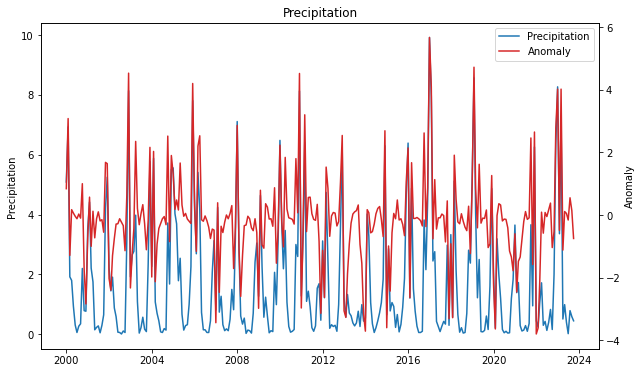

In [55]:
# copy dataframe for plotting
precip_cali_plot = precip_cali.copy()
 
# Convert 'Date' column to datetime format
precip_cali_plot['Date'] = pd.to_datetime(precip_cali_plot['Date'], format='%Y%m')
 
# Set 'Date' column as the index
precip_cali_plot.set_index('Date', inplace=True)
 
#setting the figure and axes
fig,ax = plt.subplots(figsize=(10, 6))
 
#plotting the first plot
line1 = ax.plot(precip_cali_plot.index, precip_cali['Value'], color='tab:blue', label = 'Precipitation')
ax.set_ylabel('Precipitation')
 
#using twinx to generate another y axes and plotting
ax2 = ax.twinx()
line2 = ax2.plot(precip_cali_plot.index, precip_cali['Anomaly'], color='tab:red', label = 'Anomaly')
ax2.set_ylabel('Anomaly')
 
plt.title('Precipitation')
 
# Legend
lines = line1 + line2
labels = [line.get_label() for line in lines]
plt.legend(lines, labels, loc='upper right')


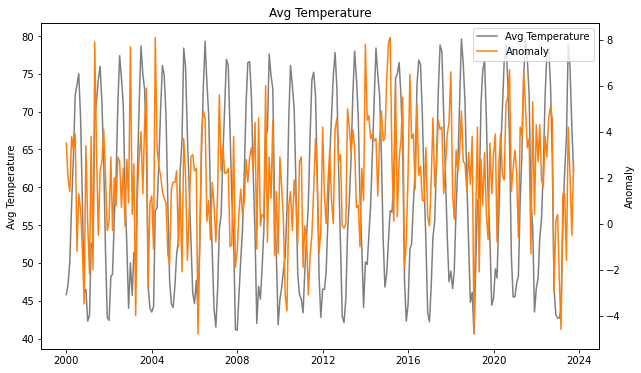

In [56]:
# copy dataframe for plotting
avg_temp_cali_plot = avg_temp_cali.copy()
 
# Convert 'Date' column to datetime format
avg_temp_cali_plot['Date'] = pd.to_datetime(avg_temp_cali_plot['Date'], format='%Y%m')
 
# Set 'Date' column as the index
avg_temp_cali_plot.set_index('Date', inplace=True)
 
#setting the figure and axes
fig,ax = plt.subplots(figsize=(10, 6))
 
#plotting the first plot
line1 = ax.plot(avg_temp_cali_plot.index, avg_temp_cali_plot['Value'], color='tab:gray', label = 'Avg Temperature')
ax.set_ylabel('Avg Temperature')
 
#using twinx to generate another y axes and plotting
ax2 = ax.twinx()
line2 = ax2.plot(avg_temp_cali_plot.index, avg_temp_cali_plot['Anomaly'], color='tab:orange', label = 'Anomaly')
ax2.set_ylabel('Anomaly')
 
plt.title('Avg Temperature')
 
# Legend
lines = line1 + line2
labels = [line.get_label() for line in lines]
plt.legend(lines, labels, loc='upper right')


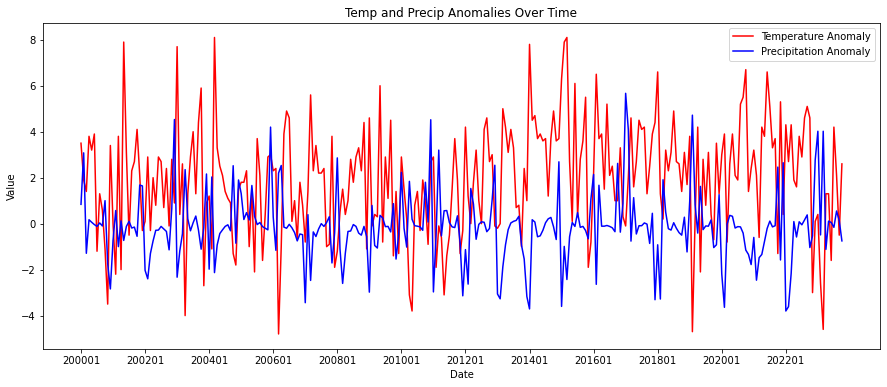

In [36]:
# Plotting the Time Series Weather Anamoly Data

plt.figure(figsize=(15, 6))
plt.plot(weather_df['Date'], weather_df['Temperature Anomaly'], label='Temperature Anomaly', color='red')
plt.plot(weather_df['Date'], weather_df['Precipitation Anomaly'], label='Precipitation Anomaly', color='blue')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Temp and Precip Anomalies Over Time')
plt.xticks(weather_df['Date'][::24])
plt.legend()
plt.show()



In [37]:
weather_join = join_df.copy() # making a copy of the join_df to use to merge to the weather data
weather_join.head()

OBJECTID  SourceOID ABCDMisc ADSPermiss Containmen ControlDat CreatedByS  \
0         1    7747595      NaN    DEFAULT        NaN        NaN    lacocad   
1         2    6384391      NaN    DEFAULT        NaN        NaN   firecode   
2         3    1383752      NaN    DEFAULT        NaN        NaN   firecode   
3         4   22499589      NaN    DEFAULT        NaN        NaN      cfcad   
4         5   23869477      NaN    DEFAULT        NaN        NaN    lacocad   

   IncidentSi  DiscoveryA DispatchCe  EstimatedC  FinalAcres  FinalFireR  \
0         NaN        0.10     CALACC         NaN         NaN         NaN   
1         NaN         NaN     CAMVIC         NaN         NaN         NaN   
2         NaN         NaN        NaN         NaN         NaN         NaN   
3         NaN        0.10     CARRCC         NaN         NaN         NaN   
4         NaN        0.01     CALACC         NaN         NaN         NaN   

  FinalFir_1 FinalFir_2 FireBehavi FireBeha_1 FireBeha_2 FireBeha_3  \
0        NaN        NaN        NaN        NaN        NaN        NaN   
1        NaN        NaN        NaN        NaN        NaN        NaN   
2        NaN        NaN        NaN        NaN        NaN        NaN   
3        NaN        NaN        NaN        NaN        NaN        NaN   
4        NaN        NaN        NaN        NaN        NaN        NaN   

      FireCause FireCauseG FireCauseS FireCode FireDepart  FireDiscov  \
0       Unknown        NaN        NaN      NaN        NaN  2020-02-28   
1           NaN        NaN        NaN     MC2S        NaN  2019-07-01   
2           NaN        NaN        NaN     KA82        NaN  2016-06-20   
3  Undetermined        NaN        NaN      NaN        NaN  2021-11-25   
4  Undetermined        NaN        NaN      NaN        NaN  2022-11-21   

  FireMgmtCo FireOutDat  FireStrate  FireStra_1  FireStra_2  FireStra_3  \
0        NaN        NaN         NaN         NaN         NaN         NaN   
1        NaN        NaN         NaN         NaN         NaN         NaN   
2        NaN        NaN         NaN         NaN         NaN         NaN   
3        NaN        NaN         NaN         NaN         NaN         NaN   
4        NaN        NaN         NaN         NaN         NaN         NaN   

  FSJobCode FSOverride  GACC ICS209Repo ICS209Re_1 ICS209Re_2 ICS209Re_3  \
0       NaN        NaN  OSCC        NaN        NaN        NaN        NaN   
1       NaN        NaN  OSCC        NaN        NaN        NaN        NaN   
2       NaN        NaN  ONCC        NaN        NaN        NaN        NaN   
3       NaN        NaN  OSCC        NaN        NaN        NaN        NaN   
4       NaN        NaN  OSCC        NaN        NaN        NaN        NaN   

  IncidentMa        IncidentNa IncidentSh IncidentTy Incident_1  InitialLat  \
0        NaN        LAC-066100        NaN         WF         FI   33.808980   
1        NaN          SYCAMORE        NaN         WF         FI         NaN   
2        NaN       RATTLESNAKE        NaN         WF         FI         NaN   
3        NaN  E 4TH ST /S D ST        NaN         WF         FI   33.782437   
4        NaN        LAC-396331        NaN         WF         FI   33.941810   

   InitialLon  InitialRes InitialR_1                                 IrwinID  \
0  -118.18070         NaN        NaN  {6A311ABB-DF4F-4947-B8DD-3900BDA784F6}   
1         NaN         NaN        NaN  {1AF2C949-B159-4D8F-8D39-90CB58BC5DD5}   
2         NaN         NaN        NaN  {1B179EA1-97CE-4699-915B-374754BCBC5B}   
3  -117.22858         NaN        NaN  {E61E387B-4ED7-4971-9604-C5D7391FAF77}   
4  -118.30902         NaN        NaN  {D24123EC-7707-4229-A206-9111FE4B6020}   

   IsFireCaus  IsFireCode  IsFSAssist  IsMultiJur  IsReimburs  IsTrespass  \
0         NaN           0         NaN         NaN         NaN         NaN   
1         NaN           0         1.0         0.0         1.0         0.0   
2         NaN           0         1.0         0.0         0.0         0.0   
3         NaN           0        

#### Feature for a merge: Fire Discovery Date</font>

In [38]:
# Extracting Data
weather_join['Date']= weather_join['FireDiscov'].str.slice(stop=4) +weather_join['FireDiscov'].str.slice(start=5,stop=7)
weather_join.head()

OBJECTID  SourceOID ABCDMisc ADSPermiss Containmen ControlDat CreatedByS  \
0         1    7747595      NaN    DEFAULT        NaN        NaN    lacocad   
1         2    6384391      NaN    DEFAULT        NaN        NaN   firecode   
2         3    1383752      NaN    DEFAULT        NaN        NaN   firecode   
3         4   22499589      NaN    DEFAULT        NaN        NaN      cfcad   
4         5   23869477      NaN    DEFAULT        NaN        NaN    lacocad   

   IncidentSi  DiscoveryA DispatchCe  EstimatedC  FinalAcres  FinalFireR  \
0         NaN        0.10     CALACC         NaN         NaN         NaN   
1         NaN         NaN     CAMVIC         NaN         NaN         NaN   
2         NaN         NaN        NaN         NaN         NaN         NaN   
3         NaN        0.10     CARRCC         NaN         NaN         NaN   
4         NaN        0.01     CALACC         NaN         NaN         NaN   

  FinalFir_1 FinalFir_2 FireBehavi FireBeha_1 FireBeha_2 FireBeha_3  \
0        NaN        NaN        NaN        NaN        NaN        NaN   
1        NaN        NaN        NaN        NaN        NaN        NaN   
2        NaN        NaN        NaN        NaN        NaN        NaN   
3        NaN        NaN        NaN        NaN        NaN        NaN   
4        NaN        NaN        NaN        NaN        NaN        NaN   

      FireCause FireCauseG FireCauseS FireCode FireDepart  FireDiscov  \
0       Unknown        NaN        NaN      NaN        NaN  2020-02-28   
1           NaN        NaN        NaN     MC2S        NaN  2019-07-01   
2           NaN        NaN        NaN     KA82        NaN  2016-06-20   
3  Undetermined        NaN        NaN      NaN        NaN  2021-11-25   
4  Undetermined        NaN        NaN      NaN        NaN  2022-11-21   

  FireMgmtCo FireOutDat  FireStrate  FireStra_1  FireStra_2  FireStra_3  \
0        NaN        NaN         NaN         NaN         NaN         NaN   
1        NaN        NaN         NaN         NaN         NaN         NaN   
2        NaN        NaN         NaN         NaN         NaN         NaN   
3        NaN        NaN         NaN         NaN         NaN         NaN   
4        NaN        NaN         NaN         NaN         NaN         NaN   

  FSJobCode FSOverride  GACC ICS209Repo ICS209Re_1 ICS209Re_2 ICS209Re_3  \
0       NaN        NaN  OSCC        NaN        NaN        NaN        NaN   
1       NaN        NaN  OSCC        NaN        NaN        NaN        NaN   
2       NaN        NaN  ONCC        NaN        NaN        NaN        NaN   
3       NaN        NaN  OSCC        NaN        NaN        NaN        NaN   
4       NaN        NaN  OSCC        NaN        NaN        NaN        NaN   

  IncidentMa        IncidentNa IncidentSh IncidentTy Incident_1  InitialLat  \
0        NaN        LAC-066100        NaN         WF         FI   33.808980   
1        NaN          SYCAMORE        NaN         WF         FI         NaN   
2        NaN       RATTLESNAKE        NaN         WF         FI         NaN   
3        NaN  E 4TH ST /S D ST        NaN         WF         FI   33.782437   
4        NaN        LAC-396331        NaN         WF         FI   33.941810   

   InitialLon  InitialRes InitialR_1                                 IrwinID  \
0  -118.18070         NaN        NaN  {6A311ABB-DF4F-4947-B8DD-3900BDA784F6}   
1         NaN         NaN        NaN  {1AF2C949-B159-4D8F-8D39-90CB58BC5DD5}   
2         NaN         NaN        NaN  {1B179EA1-97CE-4699-915B-374754BCBC5B}   
3  -117.22858         NaN        NaN  {E61E387B-4ED7-4971-9604-C5D7391FAF77}   
4  -118.30902         NaN        NaN  {D24123EC-7707-4229-A206-9111FE4B6020}   

   IsFireCaus  IsFireCode  IsFSAssist  IsMultiJur  IsReimburs  IsTrespass  \
0         NaN           0         NaN         NaN         NaN         NaN   
1         NaN           0         1.0         0.0         1.0         0.0   
2         NaN           0         1.0         0.0         0.0         0.0   
3         NaN           0        

#### Join 3: Temporal join between the weather data and wildfires using year and month ( shown in the cell after the 'Feature 2' cell)

In [39]:
weather_merge = weather_join.merge(weather_df, on='Date',how='left',suffixes=('_left','_right')) # doing left join because the dataset for the weather goes further back than the wildfire dataset
weather_merge=weather_merge.dropna(subset=['OBJECTID'])
weather_merge.head()

OBJECTID  SourceOID ABCDMisc ADSPermiss Containmen ControlDat CreatedByS  \
0         1    7747595      NaN    DEFAULT        NaN        NaN    lacocad   
1         2    6384391      NaN    DEFAULT        NaN        NaN   firecode   
2         3    1383752      NaN    DEFAULT        NaN        NaN   firecode   
3         4   22499589      NaN    DEFAULT        NaN        NaN      cfcad   
4         5   23869477      NaN    DEFAULT        NaN        NaN    lacocad   

   IncidentSi  DiscoveryA DispatchCe  EstimatedC  FinalAcres  FinalFireR  \
0         NaN        0.10     CALACC         NaN         NaN         NaN   
1         NaN         NaN     CAMVIC         NaN         NaN         NaN   
2         NaN         NaN        NaN         NaN         NaN         NaN   
3         NaN        0.10     CARRCC         NaN         NaN         NaN   
4         NaN        0.01     CALACC         NaN         NaN         NaN   

  FinalFir_1 FinalFir_2 FireBehavi FireBeha_1 FireBeha_2 FireBeha_3  \
0        NaN        NaN        NaN        NaN        NaN        NaN   
1        NaN        NaN        NaN        NaN        NaN        NaN   
2        NaN        NaN        NaN        NaN        NaN        NaN   
3        NaN        NaN        NaN        NaN        NaN        NaN   
4        NaN        NaN        NaN        NaN        NaN        NaN   

      FireCause FireCauseG FireCauseS FireCode FireDepart  FireDiscov  \
0       Unknown        NaN        NaN      NaN        NaN  2020-02-28   
1           NaN        NaN        NaN     MC2S        NaN  2019-07-01   
2           NaN        NaN        NaN     KA82        NaN  2016-06-20   
3  Undetermined        NaN        NaN      NaN        NaN  2021-11-25   
4  Undetermined        NaN        NaN      NaN        NaN  2022-11-21   

  FireMgmtCo FireOutDat  FireStrate  FireStra_1  FireStra_2  FireStra_3  \
0        NaN        NaN         NaN         NaN         NaN         NaN   
1        NaN        NaN         NaN         NaN         NaN         NaN   
2        NaN        NaN         NaN         NaN         NaN         NaN   
3        NaN        NaN         NaN         NaN         NaN         NaN   
4        NaN        NaN         NaN         NaN         NaN         NaN   

  FSJobCode FSOverride  GACC ICS209Repo ICS209Re_1 ICS209Re_2 ICS209Re_3  \
0       NaN        NaN  OSCC        NaN        NaN        NaN        NaN   
1       NaN        NaN  OSCC        NaN        NaN        NaN        NaN   
2       NaN        NaN  ONCC        NaN        NaN        NaN        NaN   
3       NaN        NaN  OSCC        NaN        NaN        NaN        NaN   
4       NaN        NaN  OSCC        NaN        NaN        NaN        NaN   

  IncidentMa        IncidentNa IncidentSh IncidentTy Incident_1  InitialLat  \
0        NaN        LAC-066100        NaN         WF         FI   33.808980   
1        NaN          SYCAMORE        NaN         WF         FI         NaN   
2        NaN       RATTLESNAKE        NaN         WF         FI         NaN   
3        NaN  E 4TH ST /S D ST        NaN         WF         FI   33.782437   
4        NaN        LAC-396331        NaN         WF         FI   33.941810   

   InitialLon  InitialRes InitialR_1                                 IrwinID  \
0  -118.18070         NaN        NaN  {6A311ABB-DF4F-4947-B8DD-3900BDA784F6}   
1         NaN         NaN        NaN  {1AF2C949-B159-4D8F-8D39-90CB58BC5DD5}   
2         NaN         NaN        NaN  {1B179EA1-97CE-4699-915B-374754BCBC5B}   
3  -117.22858         NaN        NaN  {E61E387B-4ED7-4971-9604-C5D7391FAF77}   
4  -118.30902         NaN        NaN  {D24123EC-7707-4229-A206-9111FE4B6020}   

   IsFireCaus  IsFireCode  IsFSAssist  IsMultiJur  IsReimburs  IsTrespass  \
0         NaN           0         NaN         NaN         NaN         NaN   
1         NaN           0         1.0         0.0         1.0         0.0   
2         NaN           0         1.0         0.0         0.0         0.0   
3         NaN           0        

#### Feature 2: Wildfire Count Per Temperature Feature

In [40]:
weather_merge= weather_merge.groupby(['Date'])['OBJECTID'].count()
weather_merge=weather_merge.reset_index()
weather_merge= weather_merge.merge(weather_df,on='Date',how='inner')
weather_merge.columns = ['Date','Wildfire Count Per Month','Average Temperature','Temperature Anomaly','Precipitation','Precipitation Anomaly']
weather_merge['Fire Count Per Temp']=weather_merge['Wildfire Count Per Month']/weather_merge['Average Temperature'] #Adding a feature
display(weather_merge)

Date  Wildfire Count Per Month  Average Temperature  \
0    201404                         5                 57.7   
1    201405                        87                 64.6   
2    201406                       367                 71.9   
3    201407                       793                 78.4   
4    201408                       445                 74.9   
..      ...                       ...                  ...   
110  202306                      2071                 66.7   
111  202307                      3022                 78.9   
112  202308                      1996                 75.8   
113  202309                      1329                 68.0   
114  202310                      1253                 62.1   

     Temperature Anomaly  Precipitation  Precipitation Anomaly  \
0                    3.7           1.06                  -0.57   
1                    3.9           0.35                  -0.53   
2                    3.6           0.06                  -0.29   
3                    3.7           0.22                   0.04   
4                    1.2           0.45                   0.21   
..                   ...            ...                    ...   
110                 -1.6           0.40                   0.05   
111                  4.2           0.02                  -0.16   
112                  2.1           0.79                   0.55   
113                 -0.5           0.59                   0.14   
114                  2.6           0.45                  -0.75   

     Fire Count Per Temp  
0               0.086655  
1               1.346749  
2               5.104312  
3              10.114796  
4               5.941255  
..                   ...  
110            31.049475  
111            38.301648  
112            26.332454  
113            19.544118  
114            20.177134  

[115 rows x 7 columns]

#### Feature 3: Wildfire Count Per Precipitation

In [41]:
# Now to add a similar feature, showing the wildfirecount per precipitation anomaly
weather_merge['Fire Count Per Precip']=weather_merge['Wildfire Count Per Month']/weather_merge['Precipitation'] #Adding a feature
display(weather_merge)


Date  Wildfire Count Per Month  Average Temperature  \
0    201404                         5                 57.7   
1    201405                        87                 64.6   
2    201406                       367                 71.9   
3    201407                       793                 78.4   
4    201408                       445                 74.9   
..      ...                       ...                  ...   
110  202306                      2071                 66.7   
111  202307                      3022                 78.9   
112  202308                      1996                 75.8   
113  202309                      1329                 68.0   
114  202310                      1253                 62.1   

     Temperature Anomaly  Precipitation  Precipitation Anomaly  \
0                    3.7           1.06                  -0.57   
1                    3.9           0.35                  -0.53   
2                    3.6           0.06                  -0.29   
3                    3.7           0.22                   0.04   
4                    1.2           0.45                   0.21   
..                   ...            ...                    ...   
110                 -1.6           0.40                   0.05   
111                  4.2           0.02                  -0.16   
112                  2.1           0.79                   0.55   
113                 -0.5           0.59                   0.14   
114                  2.6           0.45                  -0.75   

     Fire Count Per Temp  Fire Count Per Precip  
0               0.086655               4.716981  
1               1.346749             248.571429  
2               5.104312            6116.666667  
3              10.114796            3604.545455  
4               5.941255             988.888889  
..                   ...                    ...  
110            31.049475            5177.500000  
111            38.301648          151100.000000  
112            26.332454            2526.582278  
113            19.544118            2252.542373  
114            20.177134            2784.444444  

[115 rows x 8 columns]

#### Feaure 4: Extreme Weather Index

In [42]:
weather_merge['Extreme Weather Index']=preprocessing.scale(weather_merge['Temperature Anomaly'])-preprocessing.scale(weather_merge['Precipitation Anomaly'])
display(weather_merge)

Date  Wildfire Count Per Month  Average Temperature  \
0    201404                         5                 57.7   
1    201405                        87                 64.6   
2    201406                       367                 71.9   
3    201407                       793                 78.4   
4    201408                       445                 74.9   
..      ...                       ...                  ...   
110  202306                      2071                 66.7   
111  202307                      3022                 78.9   
112  202308                      1996                 75.8   
113  202309                      1329                 68.0   
114  202310                      1253                 62.1   

     Temperature Anomaly  Precipitation  Precipitation Anomaly  \
0                    3.7           1.06                  -0.57   
1                    3.9           0.35                  -0.53   
2                    3.6           0.06                  -0.29   
3                    3.7           0.22                   0.04   
4                    1.2           0.45                   0.21   
..                   ...            ...                    ...   
110                 -1.6           0.40                   0.05   
111                  4.2           0.02                  -0.16   
112                  2.1           0.79                   0.55   
113                 -0.5           0.59                   0.14   
114                  2.6           0.45                  -0.75   

     Fire Count Per Temp  Fire Count Per Precip  Extreme Weather Index  
0               0.086655               4.716981               0.773715  
1               1.346749             248.571429               0.832652  
2               5.104312            6116.666667               0.555597  
3              10.114796            3604.545455               0.390129  
4               5.941255             988.888889              -0.767902  
..                   ...                    ...                    ...  
110            31.049475            5177.500000              -1.844555  
111            38.301648          151100.000000               0.726121  
112            26.332454            2526.582278              -0.603298  
113            19.544118            2252.542373              -1.438653  
114            20.177134            2784.444444               0.424407  

[115 rows x 9 columns]

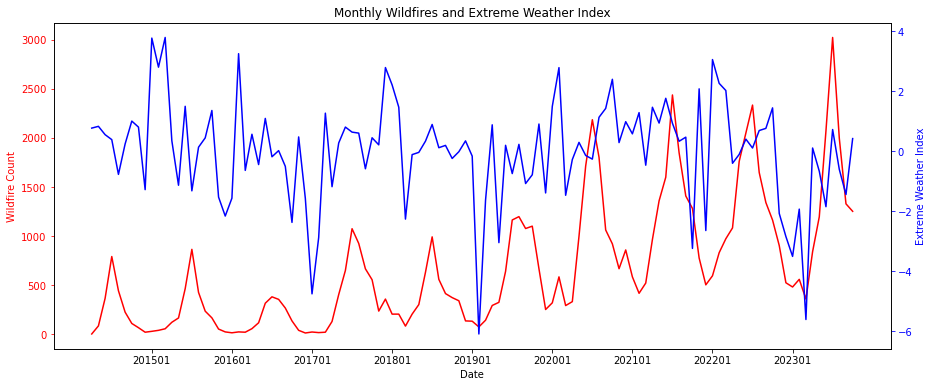

In [43]:
# Plotting Wildfire Count and Extreme WEather Index
fig, ax1 = plt.subplots(figsize=(15, 6))

ax1.plot(weather_merge['Date'], weather_merge['Wildfire Count Per Month'], label='Wildfire Count', color='red')
ax1.set_xlabel('Date')
ax1.set_ylabel('Wildfire Count', color='red')
ax1.tick_params('y', colors='red')
ax1.ticklabel_format()

ax2 = ax1.twinx()
ax2.plot(weather_merge['Date'], weather_merge['Extreme Weather Index'], label='Extreme Weather Index', color='blue')
ax2.set_ylabel('Extreme Weather Index', color='blue')
ax2.tick_params('y', colors='blue')

plt.title('Monthly Wildfires and Extreme Weather Index')
plt.xticks(weather_merge['Date'][9::12])
plt.show()

#### Feauture 5: Bucket Wildfire Size

In [44]:
bucketed_df = join_df.copy()
bucketed_df=bucketed_df.dropna(subset=['FinalAcres'])
acres_ranges = [0, 119, 1000000000] # using 119 as average acres burned by wildfires in US from 2011-2020, set upper bound high for ease
categories = ['Below Average', 'Above Average']
bucketed_df['Y/N Above Average']= pd.cut(bucketed_df['FinalAcres'], bins=acres_ranges, labels=categories, right=False)
display(bucketed_df)

OBJECTID  SourceOID ABCDMisc     ADSPermiss  Containmen  ControlDat  \
44716      44731   21031590      NaN  FIREREPORTING  2021-10-11  2021-10-11   
49724      49741    6938378      NaN        DEFAULT         NaN         NaN   
72909      72938   23870201      NaN        DEFAULT  2022-11-29         NaN   
82318      82350   23844619      NaN        DEFAULT  2022-07-08  2022-07-11   
82337      82373   23862544      NaN        DEFAULT  2022-09-26  2022-09-26   
...          ...        ...      ...            ...         ...         ...   
286299    344801   28066130      NaN        DEFAULT  2023-11-16  2023-11-16   
286305    344808   28066137      NaN        DEFAULT  2023-11-16  2023-11-16   
286334    344841   28066170      NaN        DEFAULT  2023-11-17  2023-11-17   
286348    344865   28066194      NaN        DEFAULT  2023-11-17  2023-11-17   
286383    344901   28066230      NaN        DEFAULT  2023-11-17         NaN   

       CreatedByS  IncidentSi  DiscoveryA DispatchCe   EstimatedC  FinalAcres  \
44716       cfcad   221835.00        0.01     CACICC  271147512.0   221835.00   
49724       cfcad        0.01        0.01     CATGCC          NaN        0.01   
72909       cfcad        0.01        0.01     CARRCC          NaN        0.01   
82318       cfcad        0.02        0.01     CACICC          NaN        0.02   
82337       cfcad        0.25        0.01     CALNCC          NaN        0.25   
...           ...         ...         ...        ...          ...         ...   
286299      cfcad        0.01        0.01     CAMMCC          NaN        0.01   
286305      cfcad        0.01        0.01     CACZCC          NaN        0.01   
286334      cfcad        0.01        0.01     CAFKCC          NaN        0.01   
286348      cfcad        0.01        0.01     CAFKCC          NaN        0.01   
286383      cfcad        0.01        0.01     CARRCC          NaN        0.01   

        FinalFireR FinalFir_1 FinalFir_2 FireBehavi FireBeha_1  FireBeha_2  \
44716          NaN        NaN        NaN    Minimal   Creeping  Smoldering   
49724          NaN        NaN        NaN        NaN        NaN         NaN   
72909          NaN        NaN        NaN        NaN        NaN         NaN   
82318          NaN        NaN        NaN        NaN        NaN         NaN   
82337          NaN        NaN        NaN        NaN        NaN         NaN   
...            ...        ...        ...        ...        ...         ...   
286299         NaN        NaN        NaN        NaN        NaN         NaN   
286305         NaN        NaN        NaN        NaN        NaN         NaN   
286334         NaN        NaN        NaN        NaN        NaN         NaN   
286348         NaN        NaN        NaN        NaN        NaN         NaN   
286383         NaN        NaN        NaN        NaN        NaN         NaN   

       FireBeha_3     FireCause FireCauseG FireCauseS FireCode FireDepart  \
44716     Backing  Undetermined        NaN        NaN     N8GM        NaN   
49724         NaN  Undetermined        NaN        NaN     MTP8        NaN   
72909         NaN  Undetermined        NaN        NaN      NaN        NaN   
82318         NaN  Undetermined        NaN        NaN     PT17        NaN   
82337         NaN  Undetermined        NaN        NaN      NaN        NaN   
...           ...           ...        ...        ...      ...        ...   
286299        NaN  Undetermined        NaN        NaN      NaN        NaN   
286305        NaN  Undetermined        NaN        NaN      NaN        NaN   
286334        NaN  Undetermined        NaN        NaN      NaN        NaN   
286348        NaN  Undetermined        NaN        NaN      NaN        NaN   
286383        NaN  Undetermined        NaN        NaN      NaN        NaN   

        FireDiscov       FireMgmtCo  FireOutDat  FireStrate  FireStra_1  \
44716   2021-08-15  Type 2 Incident  2023-07-31         0.0       100.0   
49724   2019-09-23              NaN         NaN         NaN         NaN   

#### Join 4: Joining the Weather data to the fire data tha contains the 'Close to Lines' feature

In [45]:
wildfire_df = join_df.copy() # making a copy to not disrupt other features if cells loaded in different order

wildfire_df['Date']= wildfire_df['FireDiscov'].str.slice(stop=4) +wildfire_df['FireDiscov'].str.slice(start=5,stop=7) # extract date in same format
wildfire_df.head()

OBJECTID  SourceOID ABCDMisc ADSPermiss Containmen ControlDat CreatedByS  \
0         1    7747595      NaN    DEFAULT        NaN        NaN    lacocad   
1         2    6384391      NaN    DEFAULT        NaN        NaN   firecode   
2         3    1383752      NaN    DEFAULT        NaN        NaN   firecode   
3         4   22499589      NaN    DEFAULT        NaN        NaN      cfcad   
4         5   23869477      NaN    DEFAULT        NaN        NaN    lacocad   

   IncidentSi  DiscoveryA DispatchCe  EstimatedC  FinalAcres  FinalFireR  \
0         NaN        0.10     CALACC         NaN         NaN         NaN   
1         NaN         NaN     CAMVIC         NaN         NaN         NaN   
2         NaN         NaN        NaN         NaN         NaN         NaN   
3         NaN        0.10     CARRCC         NaN         NaN         NaN   
4         NaN        0.01     CALACC         NaN         NaN         NaN   

  FinalFir_1 FinalFir_2 FireBehavi FireBeha_1 FireBeha_2 FireBeha_3  \
0        NaN        NaN        NaN        NaN        NaN        NaN   
1        NaN        NaN        NaN        NaN        NaN        NaN   
2        NaN        NaN        NaN        NaN        NaN        NaN   
3        NaN        NaN        NaN        NaN        NaN        NaN   
4        NaN        NaN        NaN        NaN        NaN        NaN   

      FireCause FireCauseG FireCauseS FireCode FireDepart  FireDiscov  \
0       Unknown        NaN        NaN      NaN        NaN  2020-02-28   
1           NaN        NaN        NaN     MC2S        NaN  2019-07-01   
2           NaN        NaN        NaN     KA82        NaN  2016-06-20   
3  Undetermined        NaN        NaN      NaN        NaN  2021-11-25   
4  Undetermined        NaN        NaN      NaN        NaN  2022-11-21   

  FireMgmtCo FireOutDat  FireStrate  FireStra_1  FireStra_2  FireStra_3  \
0        NaN        NaN         NaN         NaN         NaN         NaN   
1        NaN        NaN         NaN         NaN         NaN         NaN   
2        NaN        NaN         NaN         NaN         NaN         NaN   
3        NaN        NaN         NaN         NaN         NaN         NaN   
4        NaN        NaN         NaN         NaN         NaN         NaN   

  FSJobCode FSOverride  GACC ICS209Repo ICS209Re_1 ICS209Re_2 ICS209Re_3  \
0       NaN        NaN  OSCC        NaN        NaN        NaN        NaN   
1       NaN        NaN  OSCC        NaN        NaN        NaN        NaN   
2       NaN        NaN  ONCC        NaN        NaN        NaN        NaN   
3       NaN        NaN  OSCC        NaN        NaN        NaN        NaN   
4       NaN        NaN  OSCC        NaN        NaN        NaN        NaN   

  IncidentMa        IncidentNa IncidentSh IncidentTy Incident_1  InitialLat  \
0        NaN        LAC-066100        NaN         WF         FI   33.808980   
1        NaN          SYCAMORE        NaN         WF         FI         NaN   
2        NaN       RATTLESNAKE        NaN         WF         FI         NaN   
3        NaN  E 4TH ST /S D ST        NaN         WF         FI   33.782437   
4        NaN        LAC-396331        NaN         WF         FI   33.941810   

   InitialLon  InitialRes InitialR_1                                 IrwinID  \
0  -118.18070         NaN        NaN  {6A311ABB-DF4F-4947-B8DD-3900BDA784F6}   
1         NaN         NaN        NaN  {1AF2C949-B159-4D8F-8D39-90CB58BC5DD5}   
2         NaN         NaN        NaN  {1B179EA1-97CE-4699-915B-374754BCBC5B}   
3  -117.22858         NaN        NaN  {E61E387B-4ED7-4971-9604-C5D7391FAF77}   
4  -118.30902         NaN        NaN  {D24123EC-7707-4229-A206-9111FE4B6020}   

   IsFireCaus  IsFireCode  IsFSAssist  IsMultiJur  IsReimburs  IsTrespass  \
0         NaN           0         NaN         NaN         NaN         NaN   
1         NaN           0         1.0         0.0         1.0         0.0   
2         NaN           0         1.0         0.0         0.0         0.0   
3         NaN           0        

In [46]:
wildfire_df = wildfire_df.merge(weather_merge, on='Date',how='inner',suffixes=('_left','_right'))
# doing inner merge because only want rows that have data for both the weather that month and a fire
wildfire_df.head()

OBJECTID  SourceOID ABCDMisc ADSPermiss Containmen ControlDat CreatedByS  \
0         1    7747595      NaN    DEFAULT        NaN        NaN    lacocad   
1       618    7681575      NaN    DEFAULT        NaN        NaN    lacocad   
2      1313    7636376      NaN    DEFAULT        NaN        NaN    wildcad   
3      1406    7731174      NaN    DEFAULT        NaN        NaN      cfcad   
4      1524    7657574      NaN    DEFAULT        NaN        NaN    lacocad   

   IncidentSi  DiscoveryA DispatchCe  EstimatedC  FinalAcres  FinalFireR  \
0         NaN         0.1     CALACC         NaN         NaN         NaN   
1         NaN         0.1     CALACC         NaN         NaN         NaN   
2         1.0         1.0     CANCIC         NaN         NaN         NaN   
3         NaN         0.1     CARICC         NaN         NaN         NaN   
4         NaN         0.1     CALACC         NaN         NaN         NaN   

  FinalFir_1 FinalFir_2 FireBehavi FireBeha_1 FireBeha_2 FireBeha_3 FireCause  \
0        NaN        NaN        NaN        NaN        NaN        NaN   Unknown   
1        NaN        NaN        NaN        NaN        NaN        NaN   Unknown   
2        NaN        NaN        NaN        NaN        NaN        NaN   Unknown   
3        NaN        NaN        NaN        NaN        NaN        NaN   Unknown   
4        NaN        NaN        NaN        NaN        NaN        NaN   Unknown   

  FireCauseG FireCauseS FireCode FireDepart  FireDiscov FireMgmtCo FireOutDat  \
0        NaN        NaN      NaN        NaN  2020-02-28        NaN        NaN   
1        NaN        NaN      NaN        NaN  2020-02-10        NaN        NaN   
2        NaN        NaN      NaN        NaN  2020-02-04        NaN        NaN   
3        NaN        NaN     M0D8        NaN  2020-02-22        NaN        NaN   
4        NaN        NaN      NaN        NaN  2020-02-06        NaN        NaN   

   FireStrate  FireStra_1  FireStra_2  FireStra_3 FSJobCode FSOverride  GACC  \
0         NaN         NaN         NaN         NaN       NaN        NaN  OSCC   
1         NaN         NaN         NaN         NaN       NaN        NaN  OSCC   
2         NaN         NaN         NaN         NaN       NaN        NaN  ONCC   
3         NaN         NaN         NaN         NaN       NaN        NaN  ONCC   
4         NaN         NaN         NaN         NaN       NaN        NaN  OSCC   

  ICS209Repo ICS209Re_1 ICS209Re_2 ICS209Re_3 IncidentMa  IncidentNa  \
0        NaN        NaN        NaN        NaN        NaN  LAC-066100   
1        NaN        NaN        NaN        NaN        NaN  LAC-044694   
2        NaN        NaN        NaN        NaN        NaN    OCFR 198   
3        NaN        NaN        NaN        NaN        NaN      BEEGUM   
4        NaN        NaN        NaN        NaN        NaN  LAC-040212   

  IncidentSh IncidentTy Incident_1  InitialLat  InitialLon  InitialRes  \
0        NaN         WF         FI   33.808980 -118.180700         NaN   
1        NaN         WF         FI   33.923710 -118.330120         NaN   
2        NaN         RX         FI   41.333890 -123.542600         NaN   
3        NaN         WF         FI   40.347778 -122.864444         NaN   
4        NaN         WF         FI   34.601710 -118.116300         NaN   

  InitialR_1                                 IrwinID  IsFireCaus  IsFireCode  \
0        NaN  {6A311ABB-DF4F-4947-B8DD-3900BDA784F6}         NaN           0   
1        NaN  {0A1A85BC-AB9D-4983-8BE9-D5E7116C42E9}         NaN           0   
2        NaN  {918FE414-CB78-4115-A769-EA2EA2F0B644}         NaN           0   
3        NaN  {7504C1CE-49C7-4ADD-9577-9F0413C541EF}         NaN           0   
4        NaN  {308BB1DE-CAD5-447A-83BE-350FA54F4EE4}         NaN           0   

   IsFSAssist  IsMultiJur  IsReimburs  IsTrespass  IsUnifiedC LocalIncid  \
0         NaN         NaN         NaN         NaN         NaN     066100   
1         NaN         NaN         NaN         NaN         NaN     044694   
2         0.0         0.0    

#### Feature 6: Extreme Weather and Close to Line Features

In [47]:
'''
Adding two features, one that shows if the fire was close to a transmission line and the weather was
listed as extreme for that month, and one that indicates if the fire was not close to a line and the
weather was classified as still extreme.
'''

wildfire_df['Extreme Weather and Close to Transmission']= np.where((wildfire_df['Extreme Weather Index']>0) & (wildfire_df['CloseToLines']=='Y'),True, False)
wildfire_df['Extreme Weather and not Close to Transmission']= np.where((wildfire_df['Extreme Weather Index']>0) & (wildfire_df['CloseToLines']=='N'),True, False)
wildfire_df.head()

OBJECTID  SourceOID ABCDMisc ADSPermiss Containmen ControlDat CreatedByS  \
0         1    7747595      NaN    DEFAULT        NaN        NaN    lacocad   
1       618    7681575      NaN    DEFAULT        NaN        NaN    lacocad   
2      1313    7636376      NaN    DEFAULT        NaN        NaN    wildcad   
3      1406    7731174      NaN    DEFAULT        NaN        NaN      cfcad   
4      1524    7657574      NaN    DEFAULT        NaN        NaN    lacocad   

   IncidentSi  DiscoveryA DispatchCe  EstimatedC  FinalAcres  FinalFireR  \
0         NaN         0.1     CALACC         NaN         NaN         NaN   
1         NaN         0.1     CALACC         NaN         NaN         NaN   
2         1.0         1.0     CANCIC         NaN         NaN         NaN   
3         NaN         0.1     CARICC         NaN         NaN         NaN   
4         NaN         0.1     CALACC         NaN         NaN         NaN   

  FinalFir_1 FinalFir_2 FireBehavi FireBeha_1 FireBeha_2 FireBeha_3 FireCause  \
0        NaN        NaN        NaN        NaN        NaN        NaN   Unknown   
1        NaN        NaN        NaN        NaN        NaN        NaN   Unknown   
2        NaN        NaN        NaN        NaN        NaN        NaN   Unknown   
3        NaN        NaN        NaN        NaN        NaN        NaN   Unknown   
4        NaN        NaN        NaN        NaN        NaN        NaN   Unknown   

  FireCauseG FireCauseS FireCode FireDepart  FireDiscov FireMgmtCo FireOutDat  \
0        NaN        NaN      NaN        NaN  2020-02-28        NaN        NaN   
1        NaN        NaN      NaN        NaN  2020-02-10        NaN        NaN   
2        NaN        NaN      NaN        NaN  2020-02-04        NaN        NaN   
3        NaN        NaN     M0D8        NaN  2020-02-22        NaN        NaN   
4        NaN        NaN      NaN        NaN  2020-02-06        NaN        NaN   

   FireStrate  FireStra_1  FireStra_2  FireStra_3 FSJobCode FSOverride  GACC  \
0         NaN         NaN         NaN         NaN       NaN        NaN  OSCC   
1         NaN         NaN         NaN         NaN       NaN        NaN  OSCC   
2         NaN         NaN         NaN         NaN       NaN        NaN  ONCC   
3         NaN         NaN         NaN         NaN       NaN        NaN  ONCC   
4         NaN         NaN         NaN         NaN       NaN        NaN  OSCC   

  ICS209Repo ICS209Re_1 ICS209Re_2 ICS209Re_3 IncidentMa  IncidentNa  \
0        NaN        NaN        NaN        NaN        NaN  LAC-066100   
1        NaN        NaN        NaN        NaN        NaN  LAC-044694   
2        NaN        NaN        NaN        NaN        NaN    OCFR 198   
3        NaN        NaN        NaN        NaN        NaN      BEEGUM   
4        NaN        NaN        NaN        NaN        NaN  LAC-040212   

  IncidentSh IncidentTy Incident_1  InitialLat  InitialLon  InitialRes  \
0        NaN         WF         FI   33.808980 -118.180700         NaN   
1        NaN         WF         FI   33.923710 -118.330120         NaN   
2        NaN         RX         FI   41.333890 -123.542600         NaN   
3        NaN         WF         FI   40.347778 -122.864444         NaN   
4        NaN         WF         FI   34.601710 -118.116300         NaN   

  InitialR_1                                 IrwinID  IsFireCaus  IsFireCode  \
0        NaN  {6A311ABB-DF4F-4947-B8DD-3900BDA784F6}         NaN           0   
1        NaN  {0A1A85BC-AB9D-4983-8BE9-D5E7116C42E9}         NaN           0   
2        NaN  {918FE414-CB78-4115-A769-EA2EA2F0B644}         NaN           0   
3        NaN  {7504C1CE-49C7-4ADD-9577-9F0413C541EF}         NaN           0   
4        NaN  {308BB1DE-CAD5-447A-83BE-350FA54F4EE4}         NaN           0   

   IsFSAssist  IsMultiJur  IsReimburs  IsTrespass  IsUnifiedC LocalIncid  \
0         NaN         NaN         NaN         NaN         NaN     066100   
1         NaN         NaN         NaN         NaN         NaN     044694   
2         0.0         0.0    

## Possible Next Step

### We want to see how extreme weather interacts with transmission lines and wildfires.
-- to do this we can see if the proportion of wildfires started under extreme weather circumstances is higher near transmission lines than further away from transmission lines.

In [48]:
prop_near_lines = (wildfire_df['Extreme Weather and Close to Transmission']== True).sum()/(wildfire_df['CloseToLines']== 'Y').sum()
prop_near_lines

0.6375347029428096

In [49]:
prop_not_near_lines = (wildfire_df['Extreme Weather and not Close to Transmission']== True).sum()/(wildfire_df['CloseToLines']== 'N').sum()
prop_not_near_lines

0.6343324065911711

#### As we can see above, the proportion of wildfire in extreme weather conditions near powerlines (.637) is very close to the proportion of wildfires in extreme weather conditions, not near powerlines (.634), meaning extreme weather may not effect transmission line fire any more than any other type of wildfire. However, there is further analysis that could take place. We could reduce our buffer for wildfires near tranmission lines to see if we get a more accurate representation of wildfires started by transmission lines, then rerun our numbers.